# **Foundation of Deep Learning Project** 

**Master's Degree in Data Science (A.Y. 2021/2022)**<br/>
**University of Milano - Bicocca**<br/>

Group members: 
 * Emanuela Elli (892901), 
 * Federica Madon (825628)<br/>

The task of the project is the classification of the CIFAR-10 dataset.

**Before running any other command:** Runtime ➔ Change runtime type ➔ Hardware accelerator: GPU

In [ ]:
!python --version

Python 3.8.10


## Import Library

In [1]:
from matplotlib import pyplot as plt
import zipfile
from shutil import copyfile
from time import time
import numpy as np
import random as python_random
import os
import seaborn as sns
import pickle
import sys
import pandas as pd
import tarfile
from IPython.display import Javascript
import plotly.graph_objects as go
from scipy.sparse.compressed import csr_column_index2
import re, time, json

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.models import load_model 

import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10

In [2]:
# To have the same condition for all the networks
!PYTHONHASHSEED=0
np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)

# Data Management

CIFAR-10 dataset is composed by **60000 color images** (32x32) divided in 10 classes (*airplane, automobile, bird, cat, deer, frog, horse, ship, truck*). Each class is formed by 6000 images. There are available 50000 images in the training set and 10000 images in the test set. The test set is the divided in: 7000 images for the validation set and 3000 images for the test set. Each image has a single label. All these classes are mutually exclusive.

## Dataset download


In [ ]:
# Link Google Drive account
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Open file
# Change the path with the directory of our dataset
file = tarfile.open('gdrive/My Drive/FDL_Elli_Madon/Dataset/cifar-10-python.tar.gz')
#file = tarfile.open('gdrive/My Drive/Esami/Primo semestre/Foundations of Deep Learning/FDL_Elli_Madon/Dataset/cifar-10-python.tar.gz')
# Extracting file
file.extractall('/content/')
file.close()

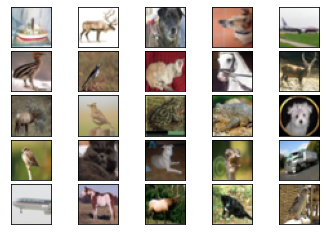

In [ ]:
# Download of the dataset
def load_batch(f_path, label_key='labels'):
    """Internal utility for parsing CIFAR data.
       ## Arguments
           fpath: path the file to parse.
           label_key: key for label data in the retrieve
                dictionary.
       ## Returns
           A tuple `(data, labels)`.
    """
    with open(f_path, 'rb') as f:
        if sys.version_info < (3,):
            d = pickle.load(f)
        else:
            d = pickle.load(f, encoding='bytes')
            # decode utf8
            d_decoded = {}
            for k, v in d.items():
                d_decoded[k.decode('utf8')] = v
            d = d_decoded
    data = d['data']
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels


def load_data(path, negatives=False):
    """Loads CIFAR10 dataset.
       # Returns
          Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """

    num_train_samples = 50000

    x_train_local = np.empty((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train_local = np.empty((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        (x_train_local[(i - 1) * 10000: i * 10000, :, :, :],
         y_train_local[(i - 1) * 10000: i * 10000]) = load_batch(fpath)

    fpath = os.path.join(path, 'test_batch')
    x_test_local, y_test_local = load_batch(fpath)

    y_train_local = np.reshape(y_train_local, (len(y_train_local), 1))
    y_test_local = np.reshape(y_test_local, (len(y_test_local), 1))

    if negatives:
        x_train_local = x_train_local.transpose(0, 2, 3, 1).astype(np.float32)
        x_test_local = x_test_local.transpose(0, 2, 3, 1).astype(np.float32)
    else:
        x_train_local = np.rollaxis(x_train_local, 1, 4)
        x_test_local = np.rollaxis(x_test_local, 1, 4)

    return (x_train_local, y_train_local), (x_test_local, y_test_local)


if __name__ == "__main__":
    """show it works"""

    cifar_10_dir = '/content/cifar-10-batches-py'

    (x_train, y_train), (x_test, y_test) = load_data(cifar_10_dir)

    # display some random training images in a 25x25 grid
    num_plot = 5
    fig, ax = plt.subplots(num_plot, num_plot)
    for m in range(num_plot):
        for n in range(num_plot):
            idx = np.random.randint(0, x_train.shape[0])
            ax[m, n].imshow(x_train[idx])
            ax[m, n].get_xaxis().set_visible(False)
            ax[m, n].get_yaxis().set_visible(False)
    fig.subplots_adjust(hspace=0.1)
    fig.subplots_adjust(wspace=0)
    plt.show()

In [ ]:
# We have decided to divide the 10000 images of the test set into 7000 images for the validation set and 3000 for the test set
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size = 0.3, random_state=0, stratify=y_test)

print(f"x_train shape:  {x_train.shape}")
print(f"y_train shape:  {y_train.shape}")
print(f"x_valid shape:  {x_valid.shape}")
print(f"y_valid shape:  {y_valid.shape}")
print(f"x_test shape:   {x_test.shape}")
print(f"y_test shape:   {y_test.shape}")

x_train shape:  (50000, 32, 32, 3)
y_train shape:  (50000, 1)
x_valid shape:  (7000, 32, 32, 3)
y_valid shape:  (7000, 1)
x_test shape:   (3000, 32, 32, 3)
y_test shape:   (3000, 1)


In [ ]:
# Define the labels of the dataset
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

meta_data_dict = unpickle('/content/cifar-10-batches-py' + "/batches.meta")
cifar_label_names = meta_data_dict[b'label_names']
cifar_label_names = np.array(cifar_label_names)

labels = []
for i in cifar_label_names:
  labels.append(i.decode('utf-8'))
labels

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

## Dataset overview

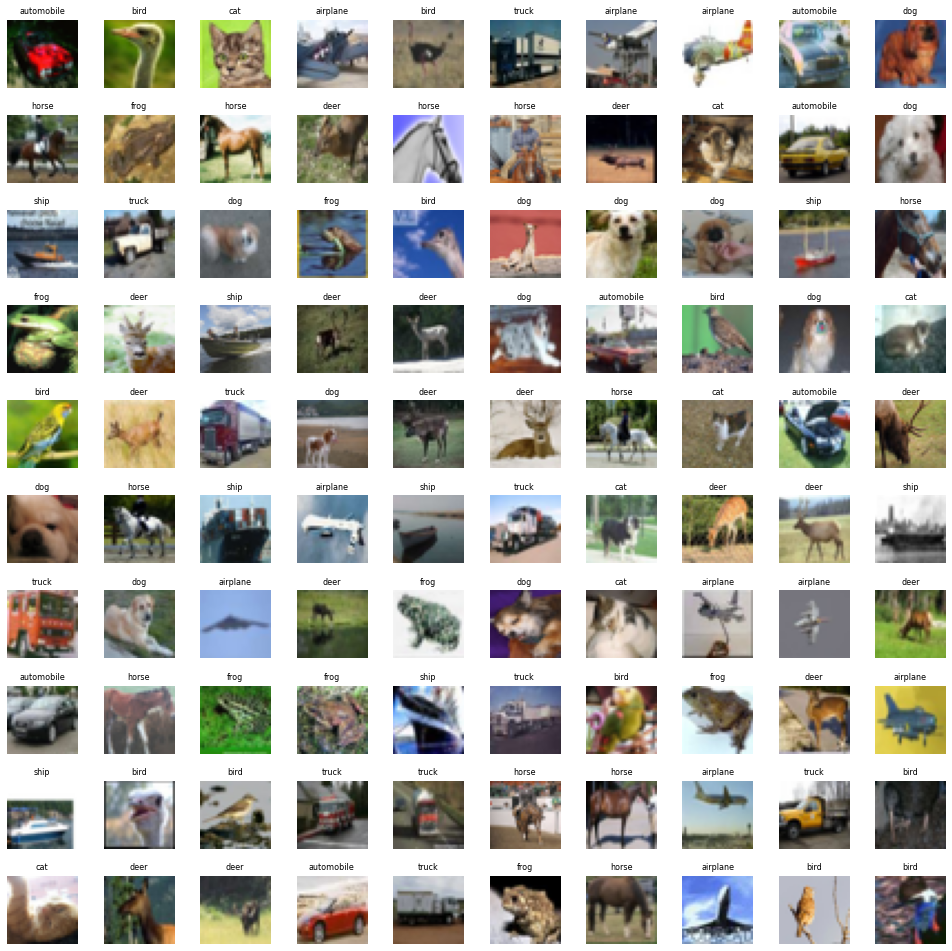

In [ ]:
# View more images in a grid format
# Define the dimensions of the plot grid 
W_grid = 10
L_grid = 10

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# with this code can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))
axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array
n_train = len(x_train) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 
    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index    
    axes[i].imshow(x_train[index,1:])
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

In [ ]:
# The graph shows the division of the dataset in train, validation and test set.
classes1, counts1 = np.unique(y_train, return_counts=True)
classes2, counts2 = np.unique(y_valid, return_counts=True)
classes3, counts3 = np.unique(y_test, return_counts=True)

fig = go.Figure()
fig.add_trace(go.Bar(
    y=labels,
    x=counts1,
    name='Train',
    orientation='h',
    marker=dict(
        color='green',
        line=dict(color='green', width=3)
    )
))
fig.add_trace(go.Bar(
    y=labels,
    x=counts2,
    name='Validation',
    orientation='h',
    marker=dict(
        color='orange',
        line=dict(color='orange', width=3)
    )
))
fig.add_trace(go.Bar(
    y=labels,
    x=counts3,
    name='Test',
    orientation='h',
    marker=dict(
        color='blue',
        line=dict(color='blue', width=3)
    )
))

fig.update_layout(barmode='stack')
fig.show()

#Defining a model from scratch


We have trained 3 different networks for our task.

## Input normalization for all the models

In [ ]:
# Normalizing
x_train = (x_train.astype('float32'))/255
x_valid = (x_valid.astype('float32'))/255
x_test = (x_test.astype('float32'))/255

# One hot encoding
y_train_cat = to_categorical(y_train,10)
y_valid_cat = to_categorical(y_valid,10)
y_test_cat = to_categorical(y_test,10)

## Early stopping

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         mode='min', verbose=1,
                                         patience=15) 

## Model 1

We have chosen to use the v5 model created during the fourth lab lesson as a basic approach and then go on to modify and improve it and try also new approaches.

In [ ]:
# Architecture definition 
inputs = keras.Input((32,32,3))

x = inputs
x = keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

x = keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

outputs = keras.layers.Dense(len(labels), activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
net1 = keras.Model(inputs, outputs)

In [ ]:
# Compile the model for training
net1.compile(loss='categorical_crossentropy',
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy', 
                     tf.keras.metrics.Precision(name='precision'),
                     tf.keras.metrics.Recall(name='recall')])

In [ ]:
net1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496 

In [ ]:
# Model training
history1 = net1.fit(x_train, y_train_cat, epochs=50, validation_data=(x_valid, y_valid_cat), callbacks = [callback])

Epoch 1/50
1563/1563 [==============================] - 30s 13ms/step - loss: 1.4567 - accuracy: 0.5519 - precision: 0.7178 - recall: 0.3847 - val_loss: 1.5289 - val_accuracy: 0.5624 - val_precision: 0.6957 - val_recall: 0.4690
Epoch 2/50
1563/1563 [==============================] - 13s 8ms/step - loss: 1.1505 - accuracy: 0.6677 - precision: 0.7776 - recall: 0.5561 - val_loss: 2.0712 - val_accuracy: 0.4207 - val_precision: 0.4589 - val_recall: 0.3584
Epoch 3/50
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0472 - accuracy: 0.7061 - precision: 0.8014 - recall: 0.6173 - val_loss: 1.9637 - val_accuracy: 0.4793 - val_precision: 0.5543 - val_recall: 0.4216
Epoch 4/50
1563/1563 [==============================] - 11s 7ms/step - loss: 0.9948 - accuracy: 0.7318 - precision: 0.8163 - recall: 0.6532 - val_loss: 1.1963 - val_accuracy: 0.6657 - val_precision: 0.7415 - val_recall: 0.5994
Epoch 5/50
1563/1563 [==============================] - 12s 7ms/step - loss: 0.9555 - accur

### Visualization and Evaluation

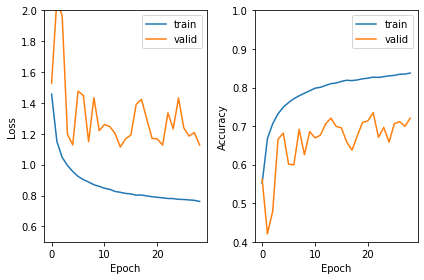

In [ ]:
# Visualization of the learning curves
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.ylim([0.5, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.ylim([0.4, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

plt.tight_layout()

#plt.savefig('Model1.png', dpi=300, facecolor='w', bbox_inches='tight', pad_inches=0)

There is overfitting and the training is finisched due to the early stopping.

In [ ]:
evaluation = net1.evaluate(x_train, y_train_cat)
print(f'Train Accuracy : {evaluation[1] * 100:.2f}%')

1563/1563 [==============================] - 6s 4ms/step - loss: 0.8212 - accuracy: 0.8090 - precision: 0.8541 - recall: 0.7677
Train Accuracy : 80.90%


In [ ]:
evaluation = net1.evaluate(x_valid, y_valid_cat)
print(f'Validation Accuracy : {evaluation[1] * 100:.2f}%')

219/219 [==============================] - 1s 4ms/step - loss: 1.1268 - accuracy: 0.7206 - precision: 0.7768 - recall: 0.6790
Validation Accuracy : 72.06%


In [ ]:
evaluation = net1.evaluate(x_test, y_test_cat)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

94/94 [==============================] - 0s 4ms/step - loss: 1.1662 - accuracy: 0.7150 - precision: 0.7679 - recall: 0.6727
Test Accuracy : 71.50%


In [ ]:
#net1.save("gdrive/My Drive/Esami/Primo semestre/Foundations of Deep Learning/FDL_Elli_Madon/Modelli/Model1.h5")

## Model 2

In [ ]:
# Architecture definition 
inputs = keras.Input((32,32,3))

x = inputs
x = keras.layers.Conv2D(32, 3, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(32, 3, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

x = Flatten()(x)
x = Dropout(0.2)(x)

x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = keras.layers.Dense(len(labels), activation="softmax")(x)
net2 = keras.Model(inputs, outputs)

In [ ]:
# Compile the model for training
net2.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy', 
                     tf.keras.metrics.Precision(name='precision'),
                     tf.keras.metrics.Recall(name='recall')])

In [ ]:
net2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 32)        9248

In [ ]:
# Model training
history2 = net2.fit(x_train, y_train_cat, epochs=50, validation_data=(x_valid, y_valid_cat), callbacks = [callback])

Epoch 1/50
1563/1563 [==============================] - 17s 10ms/step - loss: 1.3639 - accuracy: 0.5100 - precision: 0.6855 - recall: 0.3325 - val_loss: 1.3936 - val_accuracy: 0.4977 - val_precision: 0.6249 - val_recall: 0.3520
Epoch 2/50
1563/1563 [==============================] - 14s 9ms/step - loss: 1.0804 - accuracy: 0.6214 - precision: 0.7512 - recall: 0.4889 - val_loss: 1.3206 - val_accuracy: 0.5361 - val_precision: 0.7123 - val_recall: 0.3729
Epoch 3/50
1563/1563 [==============================] - 14s 9ms/step - loss: 0.9594 - accuracy: 0.6661 - precision: 0.7779 - recall: 0.5555 - val_loss: 1.2200 - val_accuracy: 0.5923 - val_precision: 0.7243 - val_recall: 0.4781
Epoch 4/50
1563/1563 [==============================] - 18s 11ms/step - loss: 0.8899 - accuracy: 0.6932 - precision: 0.7956 - recall: 0.5935 - val_loss: 1.0645 - val_accuracy: 0.6401 - val_precision: 0.7277 - val_recall: 0.5563
Epoch 5/50
1563/1563 [==============================] - 12s 8ms/step - loss: 0.8376 - accu

### Visualization and Evaluation

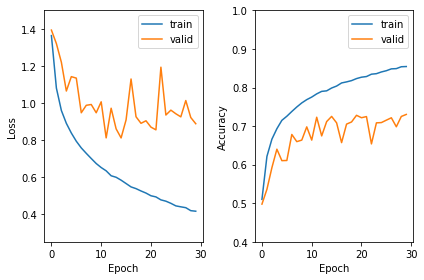

In [ ]:
# Visualization of the learning curves

plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.ylim([0.25, 1.5])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.ylim([0.4, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

plt.tight_layout()

#plt.savefig('Model2.png', dpi=300, facecolor='w', bbox_inches='tight', pad_inches=0)

There is overfitting and also in this case the training is finished due to the early stopping. Performance are better in this case.

In [ ]:
evaluation = net2.evaluate(x_train, y_train_cat)
print(f'Train Accuracy : {evaluation[1] * 100:.2f}%')

1563/1563 [==============================] - 7s 4ms/step - loss: 0.3635 - accuracy: 0.8686 - precision: 0.9042 - recall: 0.8361
Train Accuracy : 86.86%


In [ ]:
evaluation = net2.evaluate(x_valid, y_valid_cat)
print(f'Validation Accuracy : {evaluation[1] * 100:.2f}%')

219/219 [==============================] - 1s 4ms/step - loss: 0.8879 - accuracy: 0.7303 - precision: 0.7779 - recall: 0.6989
Validation Accuracy : 73.03%


In [ ]:
evaluation = net2.evaluate(x_test, y_test_cat)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

94/94 [==============================] - 0s 4ms/step - loss: 0.9317 - accuracy: 0.7217 - precision: 0.7583 - recall: 0.6903
Test Accuracy : 72.17%


In [ ]:
#net2.save("gdrive/My Drive/Esami/Primo semestre/Foundations of Deep Learning/FDL_Elli_Madon/Modelli/Model2.h5")

## Model 3

In [ ]:
# Architecture definition
inputs = keras.Input((32,32,3))

x = inputs
x = keras.layers.Conv2D(32, 3, activation='relu', padding="same", kernel_initializer='he_uniform')(x)
x = keras.layers.Conv2D(32, 3, activation='relu', padding="same", kernel_initializer='he_uniform')(x)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = Dropout(0.2)(x)

x = keras.layers.Conv2D(64, 3, activation='relu', padding="same", kernel_initializer='he_uniform')(x)
x = keras.layers.Conv2D(64, 3, activation='relu', padding="same", kernel_initializer='he_uniform')(x)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = Dropout(0.2)(x)

x = keras.layers.Conv2D(128, 3, activation='relu', padding="same", kernel_initializer='he_uniform')(x)
x = keras.layers.Conv2D(128, 3, activation='relu', padding="same", kernel_initializer='he_uniform')(x)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = Dropout(0.2)(x)
x = Flatten()(x)

x = keras.layers.Dense(128, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)

outputs = keras.layers.Dense(len(labels), activation="softmax")(x)
net3 = keras.Model(inputs, outputs)

In [ ]:
# Compile the model for training
opt = SGD(learning_rate=0.001, momentum=0.9)
net3.compile(loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy', 
                     tf.keras.metrics.Precision(name='precision'),
                     tf.keras.metrics.Recall(name='recall')])
#SGD (Stochastic Gradient Descent)

In [ ]:
net3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                             

In [ ]:
# Model training
history3 = net3.fit(x_train, y_train_cat, epochs=50, validation_data=(x_valid, y_valid_cat), callbacks = [callback])

Epoch 1/50
1563/1563 [==============================] - 20s 8ms/step - loss: 1.8938 - accuracy: 0.2963 - precision: 0.5788 - recall: 0.0462 - val_loss: 1.5674 - val_accuracy: 0.4313 - val_precision: 0.7715 - val_recall: 0.0950
Epoch 2/50
1563/1563 [==============================] - 11s 7ms/step - loss: 1.5495 - accuracy: 0.4308 - precision: 0.6502 - recall: 0.1836 - val_loss: 1.3636 - val_accuracy: 0.5144 - val_precision: 0.7398 - val_recall: 0.2501
Epoch 3/50
1563/1563 [==============================] - 11s 7ms/step - loss: 1.3975 - accuracy: 0.4951 - precision: 0.6922 - recall: 0.2766 - val_loss: 1.2994 - val_accuracy: 0.5409 - val_precision: 0.7628 - val_recall: 0.3114
Epoch 4/50
1563/1563 [==============================] - 11s 7ms/step - loss: 1.2779 - accuracy: 0.5406 - precision: 0.7184 - recall: 0.3496 - val_loss: 1.1644 - val_accuracy: 0.5839 - val_precision: 0.7470 - val_recall: 0.4057
Epoch 5/50
1563/1563 [==============================] - 12s 8ms/step - loss: 1.1783 - accura

### Visualization and Evaluation

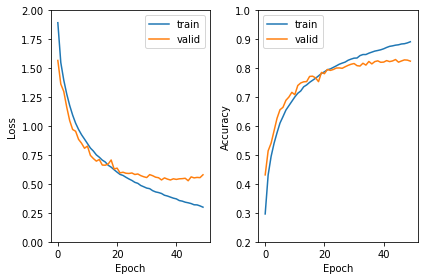

In [ ]:
# Visualization of the learning curves
plt.subplot(1, 2, 1)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.ylim([0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.ylim([0.2, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

plt.tight_layout()

#plt.savefig('Model3.png', dpi=300, facecolor='w', bbox_inches='tight', pad_inches=0)

There is overfitting but it is smaller than the other models. The training isn't finished by the early stopping.

In [ ]:
evaluation = net3.evaluate(x_train, y_train_cat)
print(f'Train Accuracy : {evaluation[1] * 100:.2f}%')

1563/1563 [==============================] - 8s 5ms/step - loss: 0.1294 - accuracy: 0.9615 - precision: 0.9713 - recall: 0.9491
Train Accuracy : 96.15%


In [ ]:
evaluation = net3.evaluate(x_valid, y_valid_cat)
print(f'Validation Accuracy : {evaluation[1] * 100:.2f}%')

219/219 [==============================] - 1s 5ms/step - loss: 0.5793 - accuracy: 0.8246 - precision: 0.8499 - recall: 0.8059
Validation Accuracy : 82.46%


In [ ]:
evaluation = net3.evaluate(x_test, y_test_cat)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

94/94 [==============================] - 0s 5ms/step - loss: 0.5967 - accuracy: 0.8123 - precision: 0.8474 - recall: 0.7977
Test Accuracy : 81.23%


In [ ]:
#net3.save("gdrive/My Drive/Esami/Primo semestre/Foundations of Deep Learning/FDL_Elli_Madon/Modelli/Model3.h5")

# Compare Models

In [ ]:
# Accuracy of the 3 models on train and validation set
accuracy1 = history1.history['accuracy']
accuracy2 = history2.history['accuracy']
accuracy3 = history3.history['accuracy']

val_accuracy1 = history1.history['val_accuracy']
val_accuracy2 = history2.history['val_accuracy']
val_accuracy3 = history3.history['val_accuracy']

print(f"Accuracy on the train set of Model 1: {accuracy1[-1]}")
print(f"Accuracy on the validation set of Model 1: {val_accuracy1[-1]}")
print(f"Accuracy on the train set of Model 2: {accuracy2[-1]}")
print(f"Accuracy on the validation set of Model 2: {val_accuracy2[-1]}")
print(f"Accuracy on the train set of Model 3: {accuracy3[-1]}")
print(f"Accuracy on the validation set of Model 3: {val_accuracy3[-1]}")

Accuracy on the train set of Model 1: 0.8375599980354309
Accuracy on the validation set of Model 1: 0.7205714583396912
Accuracy on the train set of Model 2: 0.8544399738311768
Accuracy on the validation set of Model 2: 0.7302857041358948
Accuracy on the train set of Model 3: 0.8927599787712097
Accuracy on the validation set of Model 3: 0.8264285922050476


Model 3 has the best accuracy both on train and validation test and it has also the smaller difference between this values. 

In [ ]:
# Loss of the 3 models on train and validation set
loss1 = history1.history['loss']
loss2 = history2.history['loss']
loss3 = history3.history['loss']

val_loss1 = history1.history['val_loss']
val_loss2 = history2.history['val_loss']
val_loss3 = history3.history['val_loss']

print(f"Loss on the train set of Model 1: {loss1[-1]}")
print(f"Loss on the validation set of Model 1: {val_loss1[-1]}")
print(f"Loss on the train set of Model 2: {loss2[-1]}")
print(f"Loss on the validation set of Model 2: {val_loss2[-1]}")
print(f"Loss on the train set of Model 3: {loss3[-1]}")
print(f"Loss on the validation set of Model 3: {val_loss3[-1]}")

Loss on the train set of Model 1: 0.7615630626678467
Loss on the validation set of Model 1: 1.1267856359481812
Loss on the train set of Model 2: 0.41525471210479736
Loss on the validation set of Model 2: 0.8878555297851562
Loss on the train set of Model 3: 0.30343589186668396
Loss on the validation set of Model 3: 0.5544301867485046


Model 3 is better also if it is analyzed the loss.

In [ ]:
y_pred1 = net1.predict(x_test)
y_pred1 = np.argmax(y_pred1, axis=1)
cm1 = confusion_matrix(y_test, y_pred1)

y_pred2 = net2.predict(x_test)
y_pred2 = np.argmax(y_pred2, axis=1)
cm2 = confusion_matrix(y_test, y_pred2)

y_pred3 = net3.predict(x_test)
y_pred3 = np.argmax(y_pred3, axis=1)
cm3 = confusion_matrix(y_test, y_pred3)

94/94 [==============================] - 0s 3ms/step


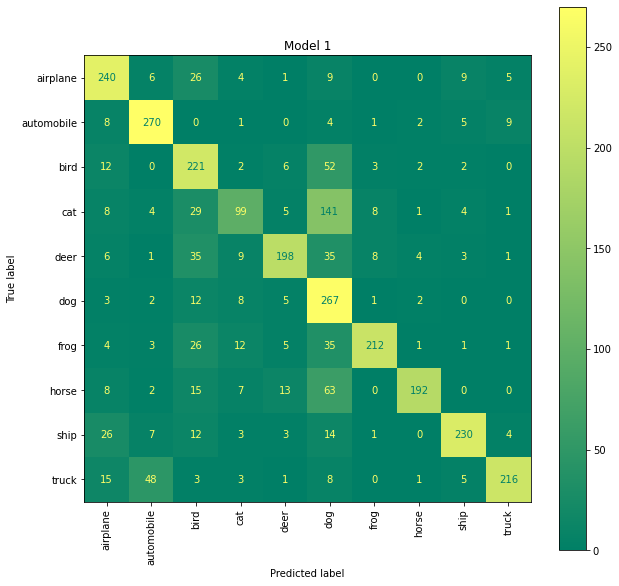

<Figure size 432x288 with 0 Axes>

In [ ]:
# Model 1
disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=labels)
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.title('Model 1')
plt.show()

#plt.savefig('Matrix_Model1.png', dpi=300, facecolor='w', bbox_inches='tight', pad_inches=0)

In [ ]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.73      0.80      0.76       300
           1       0.79      0.90      0.84       300
           2       0.58      0.74      0.65       300
           3       0.67      0.33      0.44       300
           4       0.84      0.66      0.74       300
           5       0.43      0.89      0.58       300
           6       0.91      0.71      0.79       300
           7       0.94      0.64      0.76       300
           8       0.89      0.77      0.82       300
           9       0.91      0.72      0.80       300

    accuracy                           0.71      3000
   macro avg       0.77      0.71      0.72      3000
weighted avg       0.77      0.71      0.72      3000



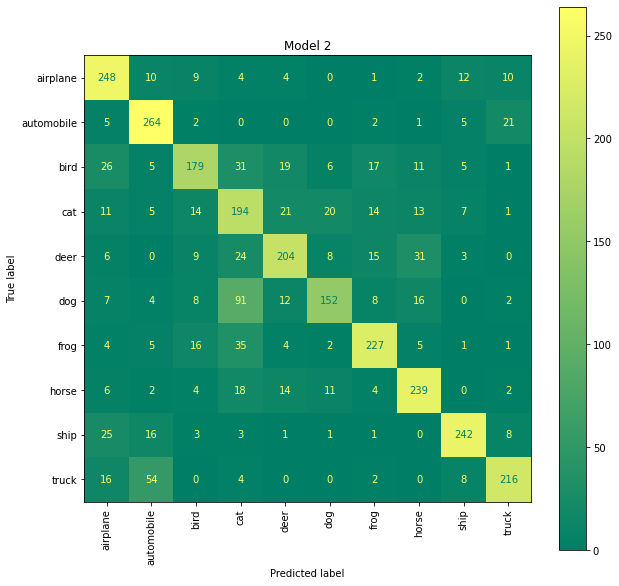

<Figure size 432x288 with 0 Axes>

In [ ]:
#Model 2
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=labels)
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.title('Model 2')
plt.show()

#plt.savefig('Matrix_Model2.png', dpi=300, facecolor='w', bbox_inches='tight', pad_inches=0)

In [ ]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.70      0.83      0.76       300
           1       0.72      0.88      0.79       300
           2       0.73      0.60      0.66       300
           3       0.48      0.65      0.55       300
           4       0.73      0.68      0.70       300
           5       0.76      0.51      0.61       300
           6       0.78      0.76      0.77       300
           7       0.75      0.80      0.77       300
           8       0.86      0.81      0.83       300
           9       0.82      0.72      0.77       300

    accuracy                           0.72      3000
   macro avg       0.73      0.72      0.72      3000
weighted avg       0.73      0.72      0.72      3000



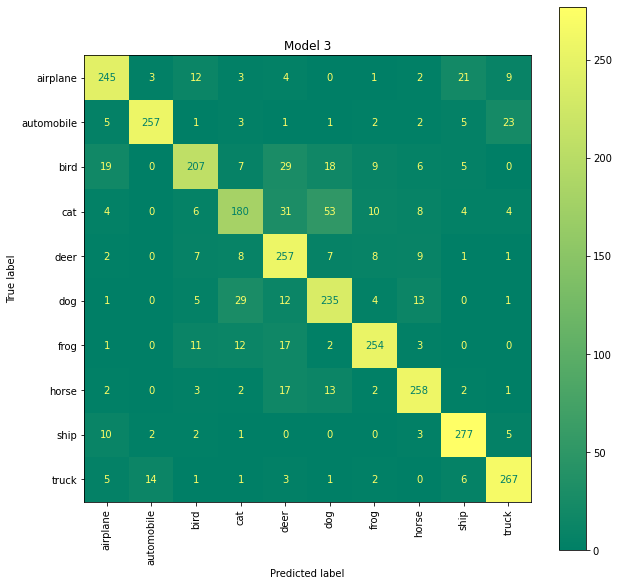

In [ ]:
#Model 3
disp = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=labels)
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.title('Model 3')
plt.show()

#plt.savefig('Matrix_Model3.png', dpi=300, facecolor='w', bbox_inches='tight', pad_inches=0)

In [ ]:
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82       300
           1       0.92      0.89      0.90       300
           2       0.82      0.71      0.76       300
           3       0.72      0.63      0.67       300
           4       0.77      0.82      0.79       300
           5       0.71      0.78      0.74       300
           6       0.86      0.89      0.88       300
           7       0.84      0.86      0.85       300
           8       0.86      0.92      0.89       300
           9       0.88      0.87      0.88       300

    accuracy                           0.82      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.82      0.82      0.82      3000



# Chosen Model

The chosen model is the model 3 and it is improved by some changes.

94/94 [==============================] - 0s 5ms/step - loss: 0.5967 - accuracy: 0.8123 - precision: 0.8474 - recall: 0.7977


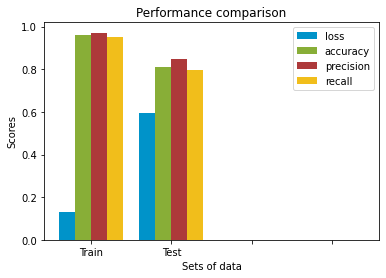

In [ ]:
N = 4
ind = np.arange(N) 
width = 0.2

train = net3.evaluate(x_train, y_train_cat)
val = net3.evaluate(x_valid, y_valid_cat)
test = net3.evaluate(x_test, y_test_cat)

loss = [train[0],  test[0], 0, 0]
accuracy = [train[1],  test[1], 0, 0]
precision = [train[2],  test[2], 0, 0]
recall = [train[3],  test[3], 0, 0]

bar1 = plt.bar(ind, loss, width, color = '#0093c9')
bar2 = plt.bar(ind+width, accuracy, width, color='#88ae37')
bar3 = plt.bar(ind+width*2, precision, width, color = '#ad393a')
bar4 = plt.bar(ind+width*3, recall, width, color = '#f1be1b')
  
plt.xlabel("Sets of data")
plt.ylabel("Scores")
plt.title("Performance comparison")
  
plt.xticks(ind + width+0.1,['Train', 'Test'])
plt.legend( (bar1, bar2, bar3, bar4), ('loss', 'accuracy', 'precision', 'recall') )
plt.show()

#plt.savefig('Histogram1.png', dpi=300, facecolor='w', bbox_inches='tight', pad_inches=0)

94/94 [==============================] - 0s 5ms/step - loss: 0.5967 - accuracy: 0.8123 - precision: 0.8474 - recall: 0.7977


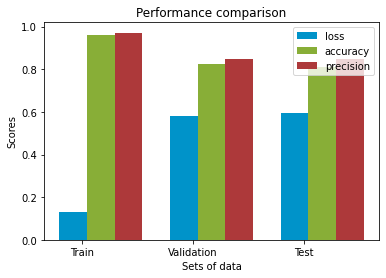

In [ ]:
N = 3
ind = np.arange(N) 
width = 0.25

train = net3.evaluate(x_train, y_train_cat)
val = net3.evaluate(x_valid, y_valid_cat)
test = net3.evaluate(x_test, y_test_cat)

loss = [train[0], val[0], test[0]]
accuracy = [train[1], val[1], test[1]]
precision = [train[2], val[2], test[2]]
recall = [train[3], val[3], test[3]]

bar1 = plt.bar(ind, loss, width, color = '#0093c9')
bar2 = plt.bar(ind+width, accuracy, width, color='#88ae37')
bar3 = plt.bar(ind+width*2, precision, width, color = '#ad393a')
#bar4 = plt.bar(ind+width*3, recall, width, color = '#f1be1b')
  
plt.xlabel("Sets of data")
plt.ylabel("Scores")
plt.title("Performance comparison")
  
plt.xticks(ind + width/3,['Train', 'Validation', 'Test'])
plt.legend( (bar1, bar2, bar3), ('loss', 'accuracy', 'precision') )
plt.show()

#plt.savefig('Histogram2.png', dpi=300, facecolor='w', bbox_inches='tight', pad_inches=0)

**Before running this part**: restart the runtime and run all the code before the part called "*Defining a model from scratch*"

## Data Augmentation

In [ ]:
# Set up image augmentation without normalization
datagen = ImageDataGenerator(rotation_range=15, horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1)
datagen.fit(x_train)

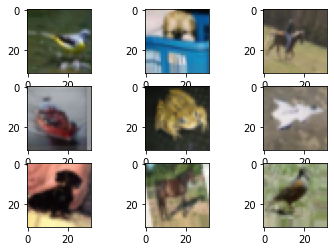

In [ ]:
# see example augmentation images
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break

## Normalization

In [ ]:
# Normalizing
x_train = (x_train.astype('float32'))/255
x_valid = (x_valid.astype('float32'))/255
x_test = (x_test.astype('float32'))/255

# One hot encoding
y_train_cat = to_categorical(y_train,10)
y_valid_cat = to_categorical(y_valid,10)
y_test_cat = to_categorical(y_test,10)

## Improvement

Model 3 is improved by the introduction of data augmentation, a grater number of epochs and also by some modifies in the structure of the network. 

In [ ]:
# Architecture definition
inputs = keras.Input((32,32,3))

x = inputs
x = keras.layers.Conv2D(32, 3, activation='relu', padding="same", kernel_initializer='he_uniform')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(32, 3, activation='relu', padding="same", kernel_initializer='he_uniform')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = Dropout(0.2)(x)

x = keras.layers.Conv2D(64, 3, activation='relu', padding="same", kernel_initializer='he_uniform')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(64, 3, activation='relu', padding="same", kernel_initializer='he_uniform')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = Dropout(0.3)(x)

x = keras.layers.Conv2D(128, 3, activation='relu', padding="same", kernel_initializer='he_uniform')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(128, 3, activation='relu', padding="same", kernel_initializer='he_uniform')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = Dropout(0.4)(x)
x = Flatten()(x)

x = keras.layers.Dense(128, activation="relu", kernel_initializer='he_uniform')(x)
x = keras.layers.BatchNormalization()(x)
x = Dropout(0.5)(x)

outputs = keras.layers.Dense(len(labels), activation="softmax")(x)
net4 = keras.Model(inputs, outputs)

In [ ]:
# Compile the model for training
opt = SGD(learning_rate=0.001, momentum=0.9)
net4.compile(loss='categorical_crossentropy',
            optimizer=opt,  
            metrics=['accuracy', 
                     tf.keras.metrics.Precision(name='precision'),
                     tf.keras.metrics.Recall(name='recall')])

In [ ]:
# Model training
history4 = net4.fit_generator(datagen.flow(x_train, y_train_cat, batch_size=128),
                              steps_per_epoch = len(x_train) / 128, 
                              epochs=300, validation_data=(x_valid, y_valid_cat)
                              #callbacks = [callback]
                              )

<ipython-input-17-b36d99fb9bc9>:2: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/300
390/390 [==============================] - 43s 83ms/step - loss: 2.3779 - accuracy: 0.2502 - precision: 0.3169 - recall: 0.1212 - val_loss: 1.7912 - val_accuracy: 0.3119 - val_precision: 0.4740 - val_recall: 0.0911
Epoch 2/300
390/390 [==============================] - 30s 78ms/step - loss: 1.8129 - accuracy: 0.3544 - precision: 0.4850 - recall: 0.1674 - val_loss: 1.5654 - val_accuracy: 0.4206 - val_precision: 0.6503 - val_recall: 0.1953
Epoch 3/300
390/390 [==============================] - 32s 83ms/step - loss: 1.6450 - accuracy: 0.4044 - precision: 0.5636 - recall: 0.2025 - val_loss: 1.4872 - val_accuracy: 0.4464 - val_precision: 0.6455 - val_recall: 0.2443
Epoch 4/300
390/390 [==============================] - 30s 77ms/step - loss: 1.5569 - accuracy: 0.4294 - precision: 0.6007 - recall: 0.2255 - val_loss: 1.5218 - val_accuracy: 0.4356 - val_precision: 0.5857 - val_recall: 0.2686
Epoch 5/300
390/390 [==============================] - 31s 80ms/step - loss: 1.4978 - accura

In [ ]:
#net4.save("gdrive/My Drive/Esami/Primo semestre/Foundations of Deep Learning/FDL_Elli_Madon/Modelli/Model_Improvement.h5")
#net4.save("gdrive/My Drive/FDL_Elli_Madon/Modelli_Elli_Madon/Model_Improvement.h5")

## Visualization and Evaluation

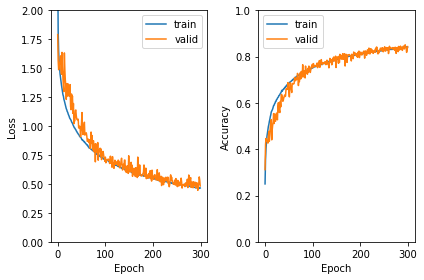

In [ ]:
# Visualization of the learning curves
plt.subplot(1, 2, 1)
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.ylim([0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

plt.tight_layout()

This model has a worse value of accuracy than the Model 3 but it has less overfitting. 

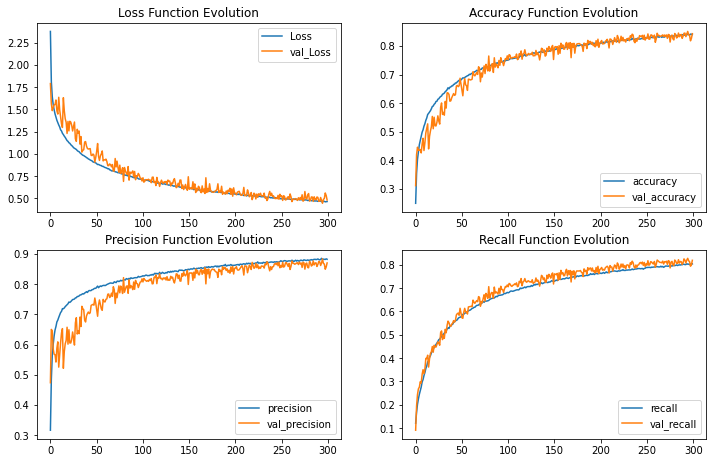

In [ ]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(history4.history['loss'], label='Loss')
plt.plot(history4.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(history4.history['accuracy'], label='accuracy')
plt.plot(history4.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(history4.history['precision'], label='precision')
plt.plot(history4.history['val_precision'], label='val_precision')
plt.title('Precision Function Evolution')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(history4.history['recall'], label='recall')
plt.plot(history4.history['val_recall'], label='val_recall')
plt.title('Recall Function Evolution')
plt.legend();

In [ ]:
accuracy = history4.history['accuracy']
val_accuracy = history4.history['val_accuracy']

print(f"Accuracy on the train set of chosen model: {accuracy[-1]}")
print(f"Accuracy on the validation set of chosen model: {val_accuracy[-1]}")

loss = history4.history['loss']
val_loss = history4.history['val_loss']

print(f"Loss on the train set of chosen model: {loss[-1]}")
print(f"Loss on the validation set of chosen model: {val_loss[-1]}")

Accuracy on the train set of chosen model: 0.8407400250434875
Accuracy on the validation set of chosen model: 0.8435714244842529
Loss on the train set of chosen model: 0.46502575278282166
Loss on the validation set of chosen model: 0.4824751317501068


In [ ]:
evaluation = net4.evaluate(x_train, y_train_cat)
print(f'Train Accuracy : {evaluation[1] * 100:.2f}%')

1563/1563 [==============================] - 8s 5ms/step - loss: 0.3700 - accuracy: 0.8730 - precision: 0.8997 - recall: 0.8508
Train Accuracy : 87.30%


In [ ]:
evaluation = net4.evaluate(x_valid, y_valid_cat)
print(f'Validation Accuracy : {evaluation[1] * 100:.2f}%')

219/219 [==============================] - 1s 5ms/step - loss: 0.4825 - accuracy: 0.8436 - precision: 0.8701 - recall: 0.8193
Validation Accuracy : 84.36%


In [ ]:
evaluation = net4.evaluate(x_test, y_test_cat)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

94/94 [==============================] - 0s 5ms/step - loss: 0.5099 - accuracy: 0.8290 - precision: 0.8614 - recall: 0.8040
Test Accuracy : 82.90%


In [ ]:
y_pred4 = net4.predict(x_test)
y_pred4 = np.argmax(y_pred4, axis=1)
cm4 = confusion_matrix(y_test, y_pred4)

94/94 [==============================] - 0s 3ms/step


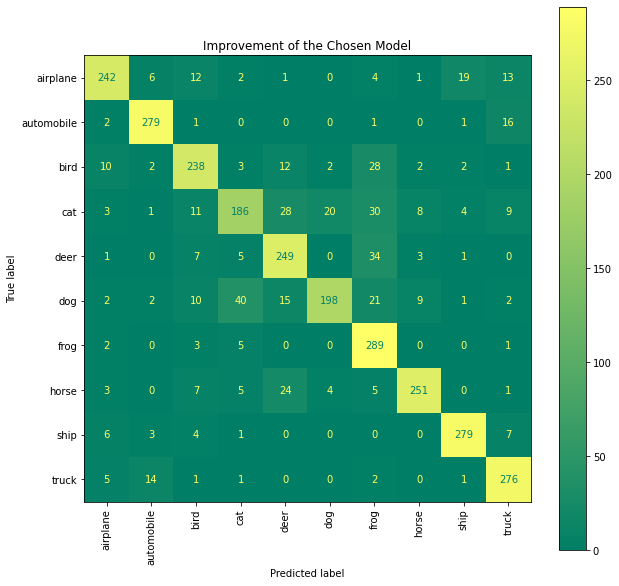

In [ ]:
# Confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm4, display_labels=labels)
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.title('Improvement of the Chosen Model')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred4))

              precision    recall  f1-score   support

           0       0.88      0.81      0.84       300
           1       0.91      0.93      0.92       300
           2       0.81      0.79      0.80       300
           3       0.75      0.62      0.68       300
           4       0.76      0.83      0.79       300
           5       0.88      0.66      0.76       300
           6       0.70      0.96      0.81       300
           7       0.92      0.84      0.87       300
           8       0.91      0.93      0.92       300
           9       0.85      0.92      0.88       300

    accuracy                           0.83      3000
   macro avg       0.84      0.83      0.83      3000
weighted avg       0.84      0.83      0.83      3000



## Test on one image

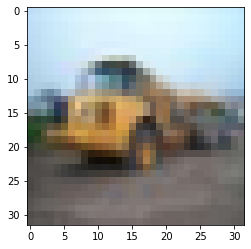

In [ ]:
my_image = x_test[100]
plt.imshow(my_image)

In [ ]:
y_test[100]

array([9])

In [ ]:
np.argmax(net4.predict(my_image.reshape(1, 32, 32, 3)))
# if the result of this cell is equal to the previous, the image is classified correctly

1/1 [==============================] - 0s 132ms/step


9

In [ ]:
predictions = net4.predict(x_test)

94/94 [==============================] - 0s 2ms/step


## Test on few images

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'green' 
    else:
        color = 'red' 

    plt.xlabel(f"{labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({labels[int(true_label)]})", 
               color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, int(true_label[i])
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')

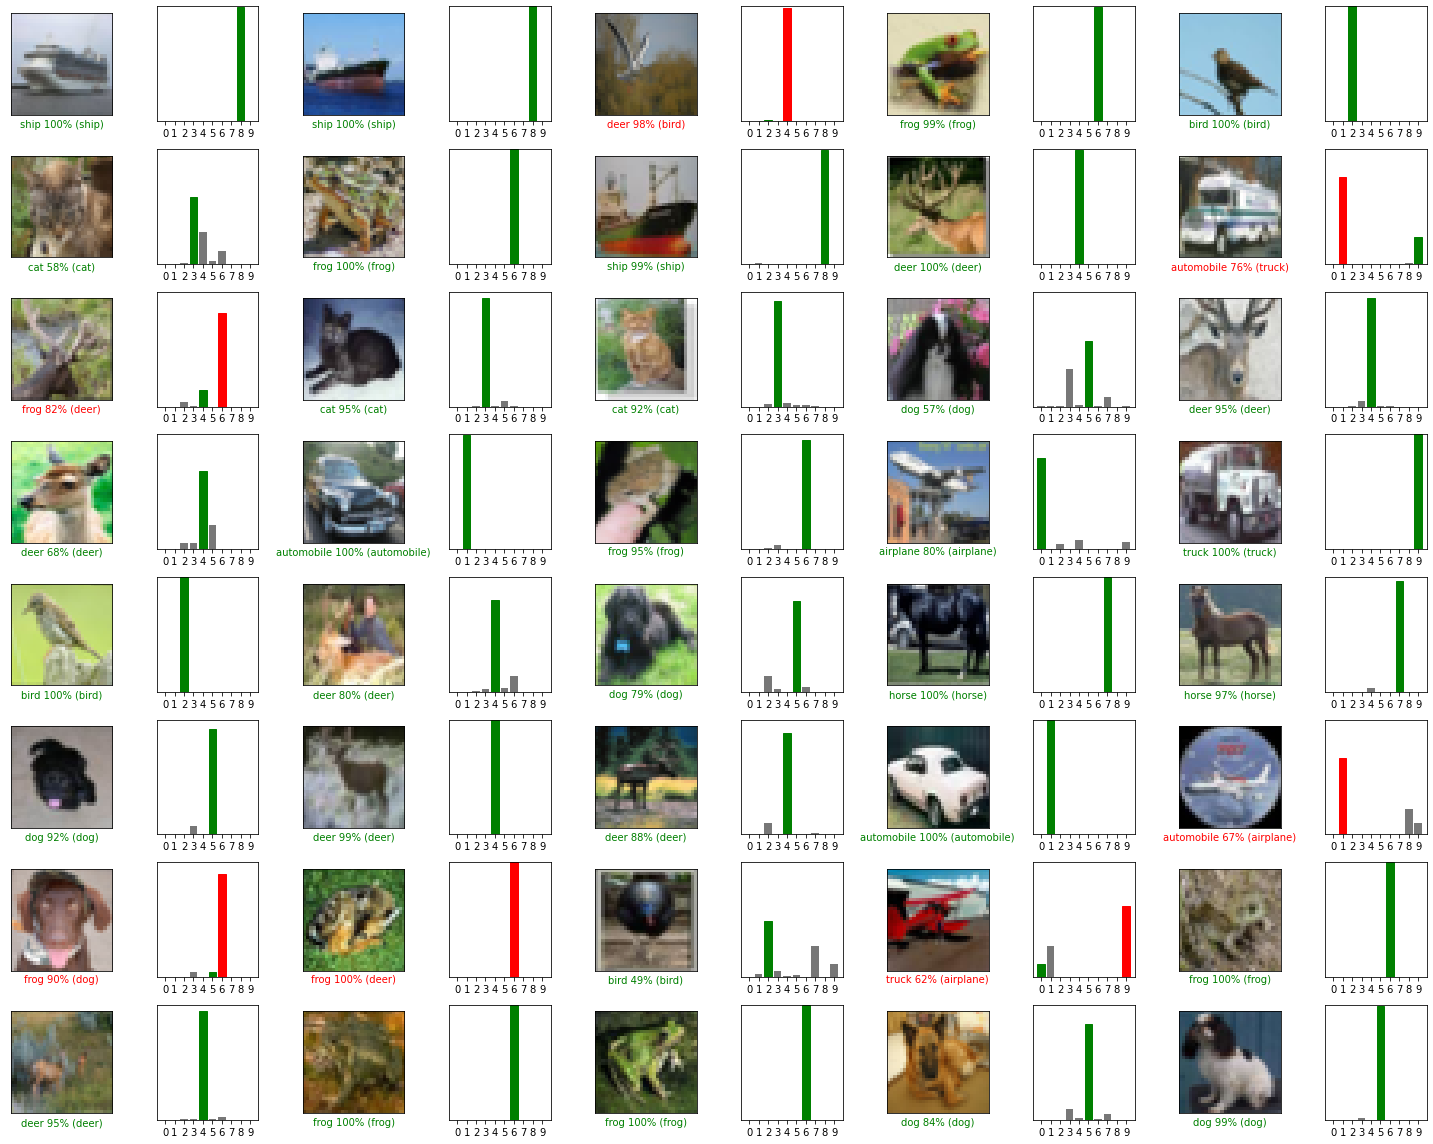

In [ ]:
# Plot the first X test images.
# The label of each image consists in their predicted labels, the percentage of the prediction and the true labels.
# Color correct predictions in green and incorrect predictions in red.
num_rows = 8
num_cols = 5
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions[i], y_test, x_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

# ViT - Vision Transformers
Steps:
* Take an image (e.g: 256×256×3).
* Turn images into smaller patches (ex:16×16×3, total 256 (N=256×256/16²) patches).
* These patches then were linearly embedded. We can think of these now as tokens.
* Use them as input for Transformer Encoder (contains multi-head self-attention).
* Perform the classification.

**Patch Generation**: divides images into patches of a given patch size and then a helper function to visualize the patches 

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size = 0.3, random_state=0, stratify=y_test)

training_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))

170498071/170498071 [==============================] - 13s 0us/step


In [ ]:
print(f"x_train shape:  {x_train.shape}")
print(f"y_train shape:  {y_train.shape}")
print(f"x_valid shape:  {x_valid.shape}")
print(f"y_valid shape:  {y_valid.shape}")
print(f"x_test shape:   {x_test.shape}")
print(f"y_test shape:   {y_test.shape}")

x_train shape:  (50000, 32, 32, 3)
y_train shape:  (50000, 1)
x_valid shape:  (7000, 32, 32, 3)
y_valid shape:  (7000, 1)
x_test shape:   (3000, 32, 32, 3)
y_test shape:   (3000, 1)


In [ ]:
# The graph shows the division of the dataset in train, validation and test set.
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
classes1, counts1 = np.unique(y_train, return_counts=True)
classes2, counts2 = np.unique(y_valid, return_counts=True)
classes3, counts3 = np.unique(y_test, return_counts=True)

fig = go.Figure()
fig.add_trace(go.Bar(
    y=labels,
    x=counts1,
    name='Train',
    orientation='h',
    marker=dict(
        color='green',
        line=dict(color='green', width=3)
    )
))
fig.add_trace(go.Bar(
    y=labels,
    x=counts2,
    name='Validation',
    orientation='h',
    marker=dict(
        color='orange',
        line=dict(color='orange', width=3)
    )
))
fig.add_trace(go.Bar(
    y=labels,
    x=counts3,
    name='Test',
    orientation='h',
    marker=dict(
        color='blue',
        line=dict(color='blue', width=3)
    )
))

fig.update_layout(barmode='stack')
fig.show()

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10, dtype='uint8')
y_test_lab = y_test 
y_test  = tf.keras.utils.to_categorical(y_test_lab, num_classes=10, dtype='uint8')
y_valid  = tf.keras.utils.to_categorical(y_valid, num_classes=10, dtype='uint8')

In [ ]:
class_types = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

training_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_data = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))

print ('check types; ', type(training_data), type(validation_data))

check types;  <class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'> <class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>


In [ ]:
class generate_patch(layers.Layer):
  def __init__(self, patch_size):
    super(generate_patch, self).__init__()
    self.patch_size = patch_size
    
  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(images=images, 
                                       sizes=[1, self.patch_size, self.patch_size, 1], 
                                       strides=[1, self.patch_size, self.patch_size, 1], rates=[1, 1, 1, 1], padding="VALID")
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims]) #here shape is (batch_size, num_patches, patch_h*patch_w*c) 
    return patches

check shapes:  (1, 32, 32, 3)
patch per image and patches shape:  64 
 (1, 64, 48)


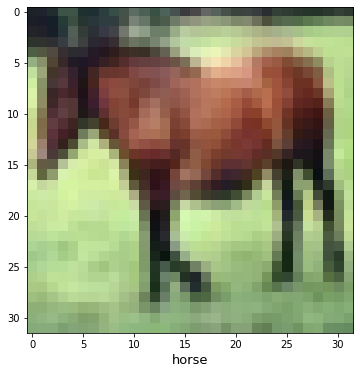

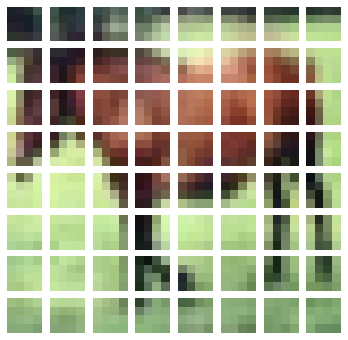

In [ ]:
from itertools import islice, count

train_iter_7im, train_iter_7label = next(islice(training_data, 7, None)) # access the 7th element from the iterator

train_iter_7im = tf.expand_dims(train_iter_7im, 0)
train_iter_7label = train_iter_7label.numpy()

print('check shapes: ', train_iter_7im.shape) 

patch_size=4 
# num patches (W * H) /P^2 where W, H are from original image, P is patch dim. 
# Original image (H * W * C), patch N * P*P *C, N num patches
generate_patch_layer = generate_patch(patch_size=patch_size)
patches = generate_patch_layer(train_iter_7im)

print ('patch per image and patches shape: ', patches.shape[1], '\n', patches.shape)

def render_image_and_patches(image, patches):
    plt.figure(figsize=(6, 6))
    plt.imshow(tf.cast(image[0], tf.uint8))
    plt.xlabel(class_types [np.argmax(train_iter_7label)], fontsize=13)
    n = int(np.sqrt(patches.shape[1]))
    plt.figure(figsize=(6, 6))
    #plt.suptitle(f"Image Patches", size=13)
    for i, patch in enumerate(patches[0]):
        ax = plt.subplot(n, n, i+1)
        patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
        ax.imshow(patch_img.numpy().astype("uint8"))
        ax.axis('off')    

render_image_and_patches(train_iter_7im, patches)

Project the patches (via a Dense layer) to a dimension that matches the query dimension in MultiHeadAttention layer and then corresponding position embedding is added.

In [ ]:
### Positonal Encoding Layer
class PatchEncode_Embed(layers.Layer):
  '''
  steps:
  1. flatten the patches 
  2. Map to dim D; patch embeddings  
  '''
  def __init__(self, num_patches, projection_dim):
    super(PatchEncode_Embed, self).__init__()
    self.num_patches = num_patches
    self.projection = layers.Dense(units=projection_dim)# activation = linear
    self.position_embedding = layers.Embedding(
        input_dim=num_patches, output_dim=projection_dim)
    
  def call(self, patch):
    positions = tf.range(start=0, limit=self.num_patches, delta=1)
    encoded = self.projection(patch) + self.position_embedding(positions)
    return encoded

In [ ]:
patch_encoder = PatchEncode_Embed(64, 64)(patches)
print (tf.shape(patch_encoder))

tf.Tensor([ 1 64 64], shape=(3,), dtype=int32)


**Patch Generation & Positional Encoding**: instead of generating patches, and then adding learnable weights via the Dense layer, we directly add this learnability through the Conv2D layer and the number of filters matches the query dimension of MultiHeadAttention layer. With that, we also need to add positional embedding and will do that by randomly initializing weights via the custom layer by extending the tf.keras.Layer.

In [ ]:
class generate_patch_conv(layers.Layer):
  '''
  this is an example to generate conv patches comparable with the image patches
  generated using tf extract image patches. This wasn't the original implementation, specially 
  the number of filters in the conv layer has nothing to do with patch size. It must be same as
  hidden dim (query/key dim) in relation to multi-head attention layer.       
  '''
  def __init__(self, patch_size):
    super(generate_patch_conv, self).__init__()
    self.patch_size = patch_size

  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = layers.Conv2D(self.patch_size*self.patch_size*3, self.patch_size, self.patch_size, padding='valid')(images)

    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches  

class generate_patch_conv_orgPaper(layers.Layer):
  '''
  original implementation, 
  hidden size = query/key dim in multi head attention layer later. 
  '''
  def __init__(self, patch_size, hidden_size):
    super(generate_patch_conv_orgPaper, self).__init__()
    self.patch_size = patch_size
    self.hidden_size = hidden_size

  def call(self, images):
    patches = layers.Conv2D(self.hidden_size, self.patch_size, self.patch_size, padding='valid', name='Embedding')(images) 
    # kernels and strides = patch size
    # the weights of the convolutional layer will be learned. 
    rows_axis, cols_axis = (1, 2) # channels last images
    seq_len = (images.shape[rows_axis] // patch_size) * (images.shape[cols_axis] // patch_size)
    x = tf.reshape(patches, [-1, seq_len, self.hidden_size])
    return x

def generate_patch_conv_orgPaper_f(patch_size, hidden_size, inputs):
  patches = layers.Conv2D(filters=hidden_size, kernel_size=patch_size, strides=patch_size, padding='valid')(inputs)
  row_axis, col_axis = (1, 2) # channels last images
  seq_len = (inputs.shape[row_axis] // patch_size) * (inputs.shape[col_axis] // patch_size)
  x = tf.reshape(patches, [-1, seq_len, hidden_size])
  return x

train_iter_7im = tf.cast(train_iter_7im, dtype=tf.float16)
generate_patch_conv_layer = generate_patch_conv(patch_size=patch_size)
patches_conv = generate_patch_conv_layer(train_iter_7im)


print ('patch per image and patches shape: ', patches_conv.shape[1], '\n', patches_conv.shape)    

generate_patch_conv_orgPaper_layer = generate_patch_conv_orgPaper(patch_size=patch_size, hidden_size=64)
patches_conv_org = generate_patch_conv_orgPaper_layer(train_iter_7im)

hidden_size=64
patches_conv_org_f = generate_patch_conv_orgPaper_f(patch_size, hidden_size, train_iter_7im)

print ('patch per image and patches shape: ', patches_conv_org.shape[1], '\n', patches_conv_org.shape)
print ('patch per image and patches shape: ', patches_conv_org_f.shape[1], '\n', patches_conv_org_f.shape)

patch per image and patches shape:  64 
 (1, 64, 48)
patch per image and patches shape:  64 
 (1, 64, 64)
patch per image and patches shape:  64 
 (1, 64, 64)


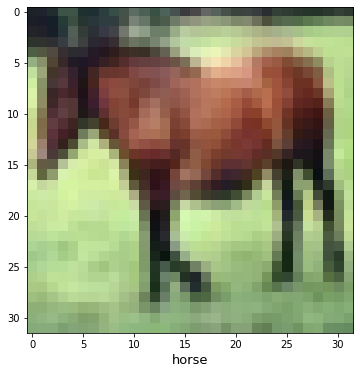

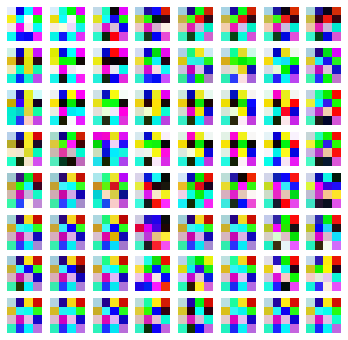

In [ ]:
def render_image_and_patches(image, patches):
    plt.figure(figsize=(6, 6))
    plt.imshow(tf.cast(image[0], tf.uint8))
    plt.xlabel(class_types [np.argmax(train_iter_7label)], fontsize=13)
    n = int(np.sqrt(patches.shape[1]))
    plt.figure(figsize=(6, 6))
    #plt.suptitle(f"Image Patches", size=13)
    for i, patch in enumerate(patches[0]):
        ax = plt.subplot(n, n, i+1)
        patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
        ax.imshow(patch_img.numpy().astype("uint8"))
        ax.axis('off')

render_image_and_patches(train_iter_7im, patches_conv)

In [ ]:
### Positonal Encoding Layer
class AddPositionEmbs(layers.Layer):
  """Adds (optionally learned) positional embeddings to the inputs."""

  def __init__(self, posemb_init=None, **kwargs):
    super().__init__(**kwargs)
    self.posemb_init = posemb_init
    #posemb_init=tf.keras.initializers.RandomNormal(stddev=0.02), name='posembed_input') # used in original code

  def build(self, inputs_shape):
    pos_emb_shape = (1, inputs_shape[1], inputs_shape[2])
    self.pos_embedding = self.add_weight('pos_embedding', pos_emb_shape, initializer=self.posemb_init)

  def call(self, inputs, inputs_positions=None):
    # inputs.shape is (batch_size, seq_len, emb_dim).
    pos_embedding = tf.cast(self.pos_embedding, inputs.dtype)

    return inputs + pos_embedding

pos_embed_layer = AddPositionEmbs(posemb_init=tf.keras.initializers.RandomNormal(stddev=0.02))
embedded_inp = pos_embed_layer(patches_conv_org)

print('embedded input shape: ', embedded_inp.shape)

embedded input shape:  (1, 64, 64)


**Transformer Encoder Block**

In [ ]:
def mlp_block_f(mlp_dim, inputs):
  x = layers.Dense(units=mlp_dim, activation=tf.nn.gelu)(inputs)
  x = layers.Dropout(rate=0.1)(x) # dropout rate is from original paper,
  x = layers.Dense(units=inputs.shape[-1], activation=tf.nn.gelu)(x)
  x = layers.Dropout(rate=0.1)(x)
  return x

def Encoder1Dblock_f(num_heads, mlp_dim, inputs):
  x = layers.LayerNormalization(dtype=inputs.dtype)(inputs)
  x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1], dropout=0.1)(x, x) # self attention multi-head, dropout_rate is from original implementation
  x = layers.Add()([x, inputs]) # 1st residual part 
  
  y = layers.LayerNormalization(dtype=x.dtype)(x)
  y = mlp_block_f(mlp_dim, y)
  y_1 = layers.Add()([y, x]) #2nd residual part 
  return y_1

# test with the embeddings as input
Encoder1Dblock_layer_out_f = Encoder1Dblock_f(4, 32, embedded_inp)

# print ('output shape of Encoder block when inputs are the embeddings: ', Encoder1Dblock_layer_out.shape)
print ('output shape of Encoder block when inputs are the embeddings: ', Encoder1Dblock_layer_out_f.shape)

output shape of Encoder block when inputs are the embeddings:  (1, 64, 64)


**Putting All Together (Vision Transformer)**: We have built up all the small pieces required for ViT (Images as word tokens, Positional encodings, Transformer encoder block); we put them together to build up the Vision Transformer. 

In [ ]:
autotune = tf.data.AUTOTUNE
rescale_layer = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2), 
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
  layers.experimental.preprocessing.RandomTranslation(0.3, 0.3, fill_mode='reflect', interpolation='bilinear',)
])

train_ds = (training_data.shuffle(40000).batch(128).map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=autotune).prefetch(autotune))
valid_ds = (validation_data.shuffle(10000).batch(32).prefetch(autotune))

def Encoder_f(num_layers, mlp_dim, num_heads, inputs):
  x = AddPositionEmbs(posemb_init=tf.keras.initializers.RandomNormal(stddev=0.02), name='posembed_input')(inputs)
  x = layers.Dropout(rate=0.2)(x)
  for _ in range(num_layers):
    x = Encoder1Dblock_f(num_heads, mlp_dim, x)

  encoded = layers.LayerNormalization(name='encoder_norm')(x)
  return encoded

# hyperparameter section 
transformer_layers = 6
patch_size = 4
hidden_size = 64
num_heads = 4
mlp_dim = 128

def build_ViT():
  inputs = layers.Input(shape=x_train.shape[1:])
  # rescaling (normalizing pixel val between 0 and 1)
  rescale = rescale_layer(inputs)
  # augmentation 
  # generate patches with conv layer
  patches = generate_patch_conv_orgPaper_f(patch_size, hidden_size, rescale)

  # ready for the transformer blocks
  encoder_out = Encoder_f(transformer_layers, mlp_dim, num_heads, patches)  

  #  final part (mlp to classification)
  #encoder_out_rank = int(tf.experimental.numpy.ndim(encoder_out))
  im_representation = tf.reduce_mean(encoder_out, axis=1)  # (1,) or (1,2)

  logits = layers.Dense(units=len(class_types), name='head', kernel_initializer=tf.keras.initializers.zeros)(im_representation) # !!! important !!! activation is linear 

  final_model = tf.keras.Model(inputs = inputs, outputs = logits)
  return final_model

model_ViT = build_ViT()
model_ViT.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 sequential_2 (Sequential)      (None, 32, 32, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 8, 8, 64)     3136        ['sequential_2[0][0]']           
                                                                                                  
 tf.reshape (TFOpLambda)        (None, 64, 64)       0           ['conv2d_2[0][0]']               
                                                                                              

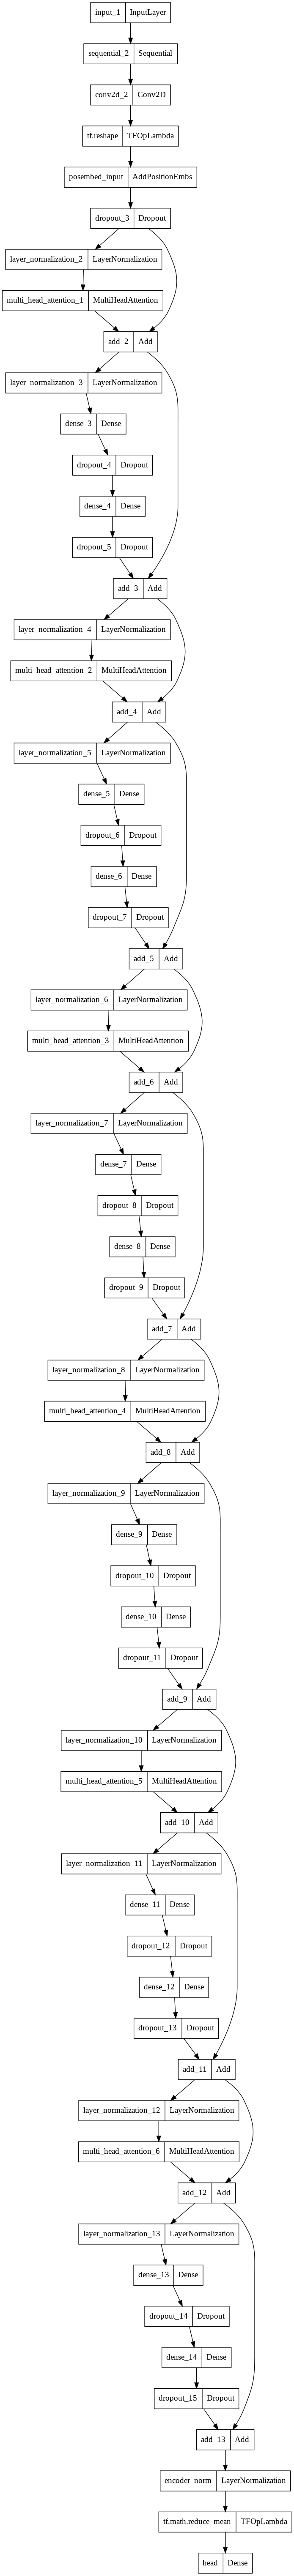

In [ ]:
tf.keras.utils.plot_model(model_ViT, rankdir='TB')

NB. `top_k_categorical_accuracy` computes the top-k-categorical accuracy rate. We take top k predicted classes from our model and see if the correct class was selected as top k. If it was we say that our model was correct.

In [ ]:
### model 
model_ViT.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3), 
                  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
                  metrics=[tf.keras.metrics.CategoricalAccuracy(name="accuracy"), tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top5 acc')]) 

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=1e-5, verbose=1)

ViT_Train = model_ViT.fit(train_ds, epochs = 40,  validation_data = valid_ds, callbacks=[reduce_lr])

Epoch 1/40
391/391 [==============================] - 32s 66ms/step - loss: 2.0522 - accuracy: 0.2088 - top5 acc: 0.7514 - val_loss: 1.8908 - val_accuracy: 0.2896 - val_top5 acc: 0.8271 - lr: 0.0020
Epoch 2/40
391/391 [==============================] - 25s 64ms/step - loss: 1.8266 - accuracy: 0.3149 - top5 acc: 0.8441 - val_loss: 1.6939 - val_accuracy: 0.3861 - val_top5 acc: 0.8773 - lr: 0.0020
Epoch 3/40
391/391 [==============================] - 25s 64ms/step - loss: 1.6510 - accuracy: 0.3917 - top5 acc: 0.8850 - val_loss: 1.5204 - val_accuracy: 0.4427 - val_top5 acc: 0.9130 - lr: 0.0020
Epoch 4/40
391/391 [==============================] - 25s 65ms/step - loss: 1.5570 - accuracy: 0.4318 - top5 acc: 0.9026 - val_loss: 1.4794 - val_accuracy: 0.4607 - val_top5 acc: 0.9170 - lr: 0.0020
Epoch 5/40
391/391 [==============================] - 25s 64ms/step - loss: 1.4932 - accuracy: 0.4573 - top5 acc: 0.9126 - val_loss: 1.4167 - val_accuracy: 0.4891 - val_top5 acc: 0.9234 - lr: 0.0020
Epoch

Save model

In [ ]:
#model_ViT.save("gdrive/My Drive/Esami/Primo semestre/Foundations of Deep Learning/FDL_Elli_Madon/Modelli/model_ViT.h5")
#model_ViT.save("gdrive/My Drive/FDL_Elli_Madon/Modelli/model_ViT.h5")

NotImplementedError: ignored

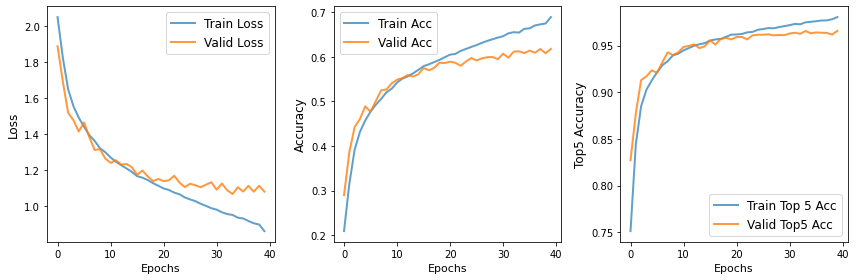

In [ ]:
### Plot train and validation curves
loss = ViT_Train.history['loss']
v_loss = ViT_Train.history['val_loss']

acc = ViT_Train.history['accuracy'] 
v_acc = ViT_Train.history['val_accuracy']

top5_acc = ViT_Train.history['top5 acc']
val_top5_acc = ViT_Train.history['val_top5 acc']
epochs = range(len(loss))

fig = plt.figure(figsize=(12, 4))
#fig.suptitle('ViT Performance', fontsize=12)
plt.subplot(1, 3, 1)
#plt.yscale('log')
plt.plot(epochs, loss, linewidth=2, alpha=0.7, label='Train Loss')
plt.plot(epochs, v_loss, linewidth=2, alpha=0.8, label='Valid Loss')
# plt.ylim(0.3, 100)
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1, 3, 2)
plt.plot(epochs, acc, linewidth=2,  alpha=0.7, label='Train Acc')
plt.plot(epochs, v_acc, linewidth=2, alpha=0.8, label='Valid Acc') 
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1, 3, 3)
plt.plot(epochs, top5_acc, linewidth=2,  alpha=0.7, label='Train Top 5 Acc')
plt.plot(epochs, val_top5_acc, linewidth=2,  alpha=0.8, label='Valid Top5 Acc') 
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Top5 Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
# plt.savefig('/content/gdrive/My Drive/Colab Notebooks/resnet/train_acc.png', dpi=250)
plt.show()

The model starts to over-fit and several changes like ReduceLearningRate, EarlyStopping etc., can be added to overcome this. Beyond that, maybe the size of data is too low for data-hungry ViT. Below there is the confusion matrix  for the test set.

In [ ]:
accuracy = ViT_Train.history['accuracy']
val_accuracy = ViT_Train.history['val_accuracy']

print(f"Accuracy on the train set of ViT model: {accuracy[-1]}")
print(f"Accuracy on the validation set of ViT model: {val_accuracy[-1]}")

loss = ViT_Train.history['loss']
val_loss = ViT_Train.history['val_loss']

print(f"Loss on the train set of ViT model: {loss[-1]}")
print(f"Loss on the validation set of ViT model: {val_loss[-1]}")

Accuracy on the train set of ViT model: 0.6896200180053711
Accuracy on the validation set of ViT model: 0.6179999709129333
Loss on the train set of ViT model: 0.8632017374038696
Loss on the validation set of ViT model: 1.0823416709899902


In [ ]:
evaluation = model_ViT.evaluate(x_train, y_train)
print(f'Train Accuracy : {evaluation[1] * 100:.2f}%')

1563/1563 [==============================] - 20s 13ms/step - loss: 0.7211 - accuracy: 0.7432 - top5 acc: 0.9877
Train Accuracy : 74.32%


In [ ]:
evaluation = model_ViT.evaluate(x_valid, y_valid)
print(f'Validation Accuracy : {evaluation[1] * 100:.2f}%')

219/219 [==============================] - 3s 13ms/step - loss: 1.0823 - accuracy: 0.6180 - top5 acc: 0.9657
Validation Accuracy : 61.80%


In [ ]:
evaluation = model_ViT.evaluate(x_test, y_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

94/94 [==============================] - 1s 13ms/step - loss: 1.0866 - accuracy: 0.6120 - top5 acc: 0.9677
Test Accuracy : 61.20%


In [ ]:
y_pred = model_ViT.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test_lab, y_pred)

94/94 [==============================] - 2s 13ms/step


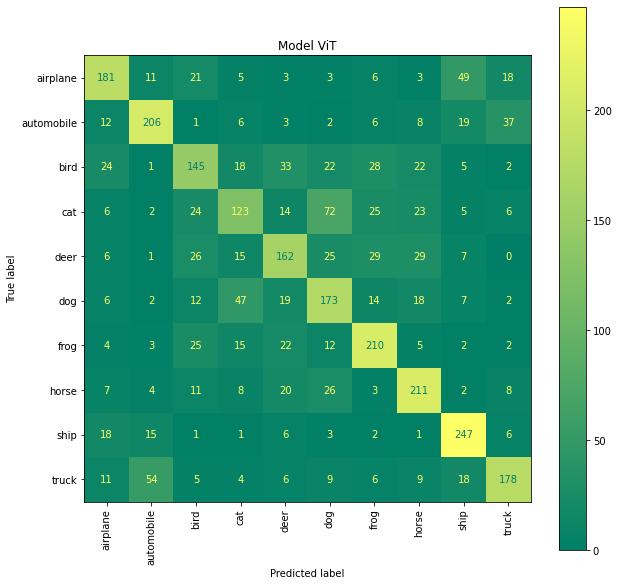

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.title('Model ViT')
plt.show()

# Transfer Learning

## VGG16

In [ ]:
from keras import callbacks
from keras import optimizers
from tensorflow.keras.models import Model
from keras.applications import vgg16 as vgg
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import scipy as sp

In [ ]:
BATCH_SIZE = 32
EPOCHS = 40
NUM_CLASSES = 10
LEARNING_RATE = 1e-4
MOMENTUM = 0.9

**Preprocessing**: Since we are about to use VGG16 as a feature extractor, the minimum size of an image it takes is 48x48. We utilize ```scipy`` to resize images to required dimensions.

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


In [ ]:
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.3, random_state=0, stratify=y_test)

In [ ]:
print(f"x_train shape:  {x_train.shape}")
print(f"y_train shape:  {y_train.shape}")
print(f"x_val shape:  {x_val.shape}")
print(f"y_val shape:  {y_val.shape}")
print(f"x_test shape:   {x_test.shape}")
print(f"y_test shape:   {y_test.shape}")

x_train shape:  (50000, 32, 32, 3)
y_train shape:  (50000, 1)
x_val shape:  (7000, 32, 32, 3)
y_val shape:  (7000, 1)
x_test shape:   (3000, 32, 32, 3)
y_test shape:   (3000, 1)


In [ ]:
# The graph shows the division of the dataset in train, validation and test set.
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
classes1, counts1 = np.unique(y_train, return_counts=True)
classes2, counts2 = np.unique(y_val, return_counts=True)
classes3, counts3 = np.unique(y_test, return_counts=True)

fig = go.Figure()
fig.add_trace(go.Bar(
    y=labels,
    x=counts1,
    name='Train',
    orientation='h',
    marker=dict(
        color='green',
        line=dict(color='green', width=3)
    )
))
fig.add_trace(go.Bar(
    y=labels,
    x=counts2,
    name='Validation',
    orientation='h',
    marker=dict(
        color='orange',
        line=dict(color='orange', width=3)
    )
))
fig.add_trace(go.Bar(
    y=labels,
    x=counts3,
    name='Test',
    orientation='h',
    marker=dict(
        color='blue',
        line=dict(color='blue', width=3)
    )
))

fig.update_layout(barmode='stack')
fig.show()

In [ ]:
Y_train = np_utils.to_categorical(y_train, NUM_CLASSES)
Y_val = np_utils.to_categorical(y_val, NUM_CLASSES)
Y_test = np_utils.to_categorical(y_test, NUM_CLASSES)

In [ ]:
import cv2
X_train = np.array([cv2.resize(x, dsize=(48, 48), interpolation=cv2.INTER_CUBIC) for x in x_train])
X_val = np.array([cv2.resize(x, dsize=(48, 48), interpolation=cv2.INTER_CUBIC) for x in x_val])
X_test = np.array([cv2.resize(x, dsize=(48, 48), interpolation=cv2.INTER_CUBIC) for x in x_test])

**Prepare the Model**:
* Load VGG16 without the top classification layer
* Prepare a custom classifier
* Sack both models on top of each other

In [ ]:
base_model = vgg.VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
# Extract the last layer from third block of vgg16 model
last = base_model.get_layer('block3_pool').output

In [ ]:
# Add classification layers on top of it
x = GlobalAveragePooling2D()(last)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model_VGG16 = Model(base_model.input, pred)

We freeze the layers of VGG16 to train the custom classifier.

In [ ]:
for layer in base_model.layers:
     layer.trainable = False

In [ ]:
model_VGG16.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                     tf.keras.metrics.Recall(name='recall')])

In [ ]:
model_VGG16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

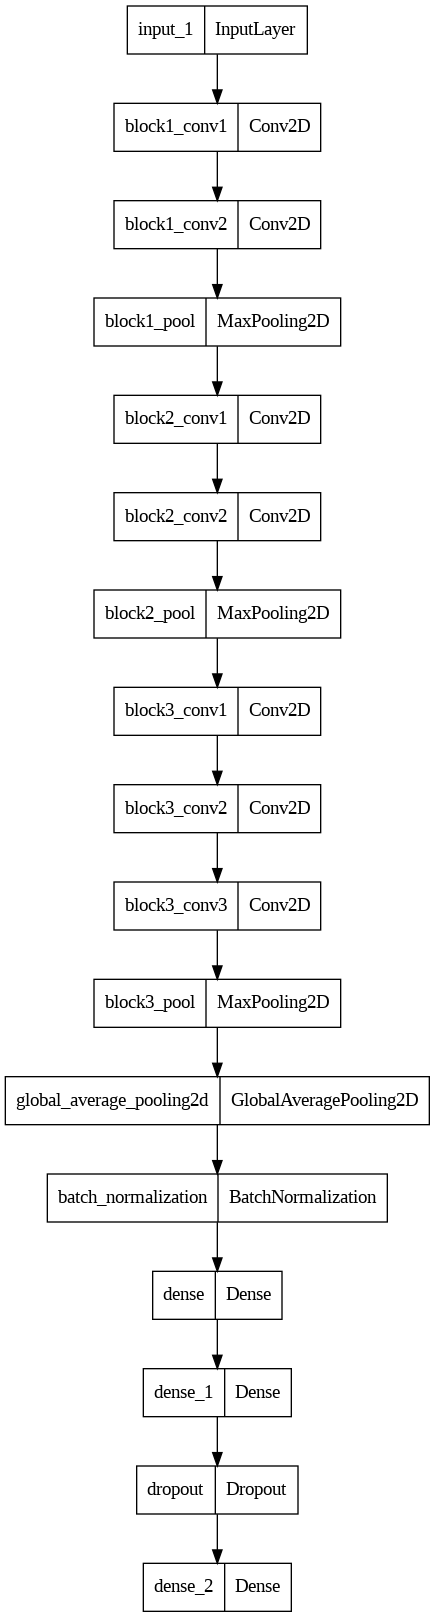

In [ ]:
tf.keras.utils.plot_model(model_VGG16, rankdir='TB')

**Data Augmentation**: to help model generalize and overcome the limitations of a small dataset.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1. / 255, horizontal_flip=False)

In [ ]:
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE)

In [ ]:
val_datagen = ImageDataGenerator(rescale=1. / 255, horizontal_flip=False)

val_datagen.fit(X_val)
val_generator = val_datagen.flow(X_val, Y_val, batch_size=BATCH_SIZE)

**Train the Model**

In [ ]:
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

history = model_VGG16.fit(train_generator, steps_per_epoch=train_steps_per_epoch, validation_data=val_generator, validation_steps=val_steps_per_epoch,
                    epochs=EPOCHS, verbose=1)

Epoch 1/40
1562/1562 [==============================] - 26s 12ms/step - loss: 0.2731 - accuracy: 0.4048 - precision: 0.5793 - recall: 0.2396 - val_loss: 0.1899 - val_accuracy: 0.5970 - val_precision: 0.7402 - val_recall: 0.4533
Epoch 2/40
1562/1562 [==============================] - 18s 11ms/step - loss: 0.2036 - accuracy: 0.5728 - precision: 0.6895 - recall: 0.4543 - val_loss: 0.1650 - val_accuracy: 0.6540 - val_precision: 0.7580 - val_recall: 0.5477
Epoch 3/40
1562/1562 [==============================] - 19s 12ms/step - loss: 0.1801 - accuracy: 0.6275 - precision: 0.7215 - recall: 0.5331 - val_loss: 0.1507 - val_accuracy: 0.6875 - val_precision: 0.7666 - val_recall: 0.6016
Epoch 4/40
1562/1562 [==============================] - 18s 12ms/step - loss: 0.1666 - accuracy: 0.6560 - precision: 0.7416 - recall: 0.5769 - val_loss: 0.1428 - val_accuracy: 0.6991 - val_precision: 0.7727 - val_recall: 0.6259
Epoch 5/40
1562/1562 [==============================] - 18s 11ms/step - loss: 0.1576 - a

Save model

In [ ]:
#model_VGG16.save("gdrive/My Drive/Esami/Primo semestre/Foundations of Deep Learning/FDL_Elli_Madon/Modelli/model_VGG16.h5")
#model_VGG16.save("gdrive/My Drive/FDL_Elli_Madon/Modelli/model_VGG16.h5")

**Analyze Model Performance**

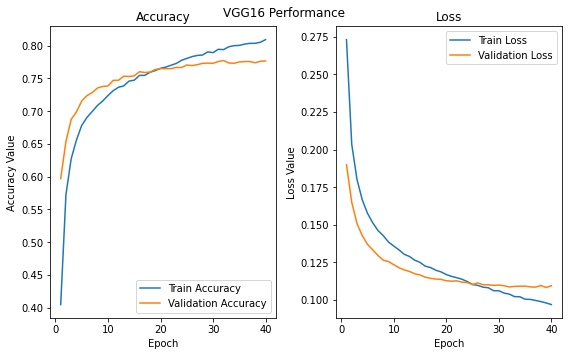

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))
t = f.suptitle('VGG16 Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,EPOCHS+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
#ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
#ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")
plt.tight_layout()

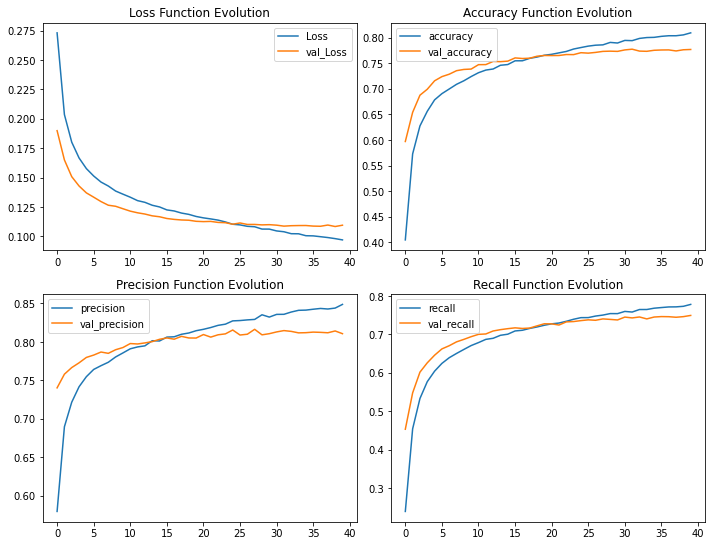

In [ ]:
plt.figure(figsize=(10, 15))

plt.subplot(4, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(history.history['precision'], label='precision')
plt.plot(history.history['val_precision'], label='val_precision')
plt.title('Precision Function Evolution')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label='val_recall')
plt.title('Recall Function Evolution')
plt.legend();

plt.tight_layout()

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

print(f"Accuracy on the train set of VGG16 model: {accuracy[-1]}")
print(f"Accuracy on the validation set of VGG16 model: {val_accuracy[-1]}")

loss = history.history['loss']
val_loss = history.history['val_loss']

print(f"Loss on the train set of VGG16 model: {loss[-1]}")
print(f"Loss on the validation set of VGG16 model: {val_loss[-1]}")

Accuracy on the train set of VGG16 model: 0.8092779517173767
Accuracy on the validation set of VGG16 model: 0.7768061757087708
Loss on the train set of VGG16 model: 0.09689459204673767
Loss on the validation set of VGG16 model: 0.10939531773328781


In [ ]:
y_pred = model_VGG16.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)

94/94 [==============================] - 1s 8ms/step


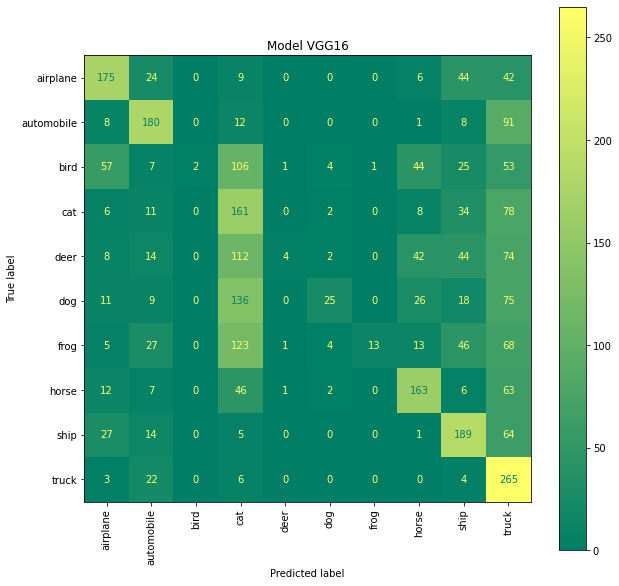

In [ ]:
class_types = labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_types)
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.title('Model VGG16')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.58      0.57       300
           1       0.57      0.60      0.59       300
           2       1.00      0.01      0.01       300
           3       0.22      0.54      0.32       300
           4       0.57      0.01      0.03       300
           5       0.64      0.08      0.15       300
           6       0.93      0.04      0.08       300
           7       0.54      0.54      0.54       300
           8       0.45      0.63      0.53       300
           9       0.30      0.88      0.45       300

    accuracy                           0.39      3000
   macro avg       0.58      0.39      0.33      3000
weighted avg       0.58      0.39      0.33      3000



In [ ]:
evaluation = model_VGG16.evaluate(X_train, Y_train)
print(f'Train Accuracy : {evaluation[1] * 100:.2f}%')

1563/1563 [==============================] - 17s 10ms/step - loss: 31.8935 - accuracy: 0.3927 - precision: 0.3927 - recall: 0.3927
Train Accuracy : 39.27%


In [ ]:
evaluation = model_VGG16.evaluate(X_val, Y_val)
print(f'Validation Accuracy : {evaluation[1] * 100:.2f}%')

219/219 [==============================] - 2s 9ms/step - loss: 32.8366 - accuracy: 0.3894 - precision: 0.3894 - recall: 0.3894
Validation Accuracy : 38.94%


In [ ]:
evaluation = model_VGG16.evaluate(X_test, Y_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

94/94 [==============================] - 1s 9ms/step - loss: 32.6886 - accuracy: 0.3923 - precision: 0.3923 - recall: 0.3923
Test Accuracy : 39.23%


## ResNet50

In [3]:
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.9.2


In [4]:
BATCH_SIZE = 32 
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
(X_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 14s 0us/step


In [6]:
X_val, X_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.3, random_state=0, stratify=y_test)

In [7]:
print(f"X_train shape:  {X_train.shape}")
print(f"y_train shape:  {y_train.shape}")
print(f"X_val shape:  {X_val.shape}")
print(f"y_val shape:  {y_val.shape}")
print(f"X_test shape:   {X_test.shape}")
print(f"y_test shape:   {y_test.shape}")

X_train shape:  (50000, 32, 32, 3)
y_train shape:  (50000, 1)
X_val shape:  (7000, 32, 32, 3)
y_val shape:  (7000, 1)
X_test shape:   (3000, 32, 32, 3)
y_test shape:   (3000, 1)


In [8]:
# The graph shows the division of the dataset in train, validation and test set.
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
classes1, counts1 = np.unique(y_train, return_counts=True)
classes2, counts2 = np.unique(y_val, return_counts=True)
classes3, counts3 = np.unique(y_test, return_counts=True)

fig = go.Figure()
fig.add_trace(go.Bar(
    y=labels,
    x=counts1,
    name='Train',
    orientation='h',
    marker=dict(
        color='green',
        line=dict(color='green', width=3)
    )
))
fig.add_trace(go.Bar(
    y=labels,
    x=counts2,
    name='Validation',
    orientation='h',
    marker=dict(
        color='orange',
        line=dict(color='orange', width=3)
    )
))
fig.add_trace(go.Bar(
    y=labels,
    x=counts3,
    name='Test',
    orientation='h',
    marker=dict(
        color='blue',
        line=dict(color='blue', width=3)
    )
))

fig.update_layout(barmode='stack')
fig.show()

**Preprocessing**: we perform normalization on images using the function preprocess_input from the ResNet50 model in Keras.

In [9]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims

In [10]:
train_X = preprocess_image_input(X_train)
valid_X = preprocess_image_input(X_val)
test_X = preprocess_image_input(X_test)

**Prepare the Model**: we perform transfer learning on ResNet50 available in Keras loading pre-trained imagenet weights to the model (we retain all layers of ResNet50 along with the final classification layers).


In [11]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights. 
Input size is 224 x 224.
'''
def feature_extractor(inputs):
  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor

'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):
    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it. 
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)

  model.compile(optimizer='SGD', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
  
  return model

model_ResNet50 = define_compile_model()
model_ResNet50.summary()

94765736/94765736 [==============================] - 6s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                              

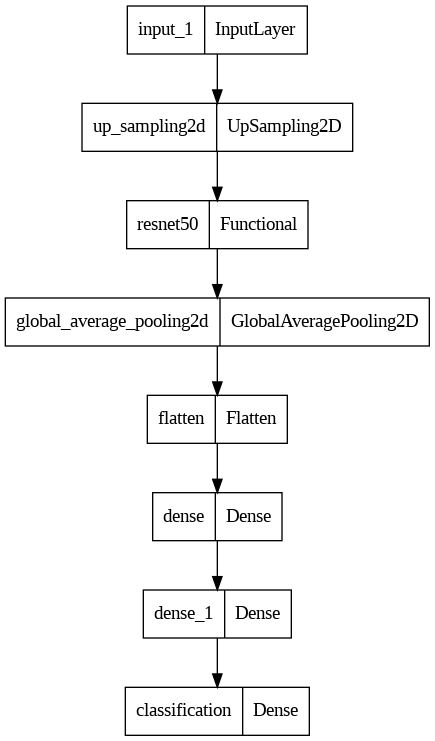

In [12]:
tf.keras.utils.plot_model(model_ResNet50, rankdir='TB')

**Train the model**

In [13]:
EPOCHS = 8
historyRes = model_ResNet50.fit(train_X, y_train, epochs=EPOCHS, validation_data = (valid_X, y_val), batch_size=64)

Epoch 1/8
782/782 [==============================] - 559s 697ms/step - loss: 0.4000 - accuracy: 0.8698 - val_loss: 0.2126 - val_accuracy: 0.9270
Epoch 2/8
782/782 [==============================] - 542s 693ms/step - loss: 0.1038 - accuracy: 0.9663 - val_loss: 0.1949 - val_accuracy: 0.9369
Epoch 3/8
782/782 [==============================] - 543s 694ms/step - loss: 0.0348 - accuracy: 0.9902 - val_loss: 0.1703 - val_accuracy: 0.9497
Epoch 4/8
782/782 [==============================] - 542s 693ms/step - loss: 0.0139 - accuracy: 0.9968 - val_loss: 0.1698 - val_accuracy: 0.9514
Epoch 5/8
782/782 [==============================] - 542s 693ms/step - loss: 0.0078 - accuracy: 0.9986 - val_loss: 0.1762 - val_accuracy: 0.9540
Epoch 6/8
782/782 [==============================] - 563s 719ms/step - loss: 0.0051 - accuracy: 0.9989 - val_loss: 0.2564 - val_accuracy: 0.9399
Epoch 7/8
782/782 [==============================] - 542s 693ms/step - loss: 0.0036 - accuracy: 0.9994 - val_loss: 0.1806 - val_ac

Save model

In [ ]:
#model_ResNet50.save("gdrive/My Drive/FDL_Elli_Madon/Modelli/model_ResNet50.h5")
#model_ResNet50.save("gdrive/My Drive/model_ResNet50.h5")

**Analyze Model Performance**

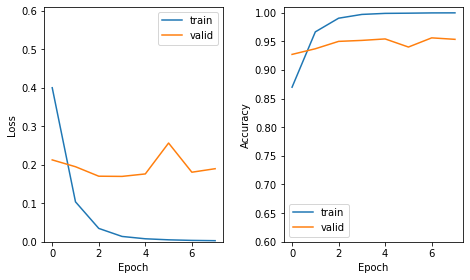

In [18]:
plt.subplot(1, 2, 1)
plt.plot(historyRes.history['loss'])
plt.plot(historyRes.history['val_loss'])
plt.ylim([0, 0.61])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(historyRes.history['accuracy'])
plt.plot(historyRes.history['val_accuracy'])
plt.ylim([0.6, 1.01])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

plt.tight_layout()
plt.gcf().subplots_adjust(left=0.005)

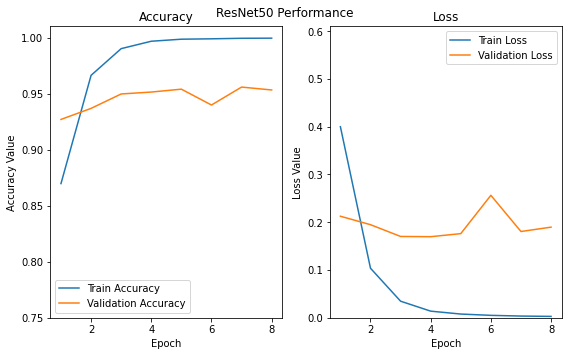

In [39]:
f, (ax3, ax4) = plt.subplots(1, 2, figsize=(8, 5))
t = f.suptitle('ResNet50 Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,EPOCHS+1))
ax3.plot(epochs, historyRes.history['accuracy'], label='Train Accuracy')
ax3.plot(epochs, historyRes.history['val_accuracy'], label='Validation Accuracy')
#ax1.set_xticks(epochs)
ax3.set_ylabel('Accuracy Value')
ax3.set_xlabel('Epoch')
ax3.set_title('Accuracy')
ax3.set_ylim([0.75, 1.01])
l1 = ax3.legend(loc="best")

ax4.plot(epochs, historyRes.history['loss'], label='Train Loss')
ax4.plot(epochs, historyRes.history['val_loss'], label='Validation Loss')
#ax2.set_xticks(epochs)
ax4.set_ylabel('Loss Value')
ax4.set_xlabel('Epoch')
ax4.set_title('Loss')
ax4.set_ylim([0, 0.61])
l2 = ax4.legend(loc="best")
plt.tight_layout()

In [26]:
accuracy = historyRes.history['accuracy']
val_accuracy = historyRes.history['val_accuracy']

print(f"Accuracy on the train set of ResNet50 model: {accuracy[-1]}")
print(f"Accuracy on the validation set of ResNet50 model: {val_accuracy[-1]}")

loss = historyRes.history['loss']
val_loss = historyRes.history['val_loss']

print(f"Loss on the train set of ResNet50 model: {loss[-1]}")
print(f"Loss on the validation set of ResNet50 model: {val_loss[-1]}")

Accuracy on the train set of ResNet50 model: 0.9994999766349792
Accuracy on the validation set of ResNet50 model: 0.9532856941223145
Loss on the train set of ResNet50 model: 0.0029097606893628836
Loss on the validation set of ResNet50 model: 0.1897573471069336


In [27]:
evaluation = model_ResNet50.evaluate(train_X, y_train)
print(f'Train Accuracy : {evaluation[1] * 100:.2f}%')

1563/1563 [==============================] - 153s 97ms/step - loss: 0.0010 - accuracy: 0.9999
Train Accuracy : 99.99%


In [28]:
evaluation = model_ResNet50.evaluate(valid_X, y_val)
print(f'Validation Accuracy : {evaluation[1] * 100:.2f}%')

219/219 [==============================] - 21s 98ms/step - loss: 0.1898 - accuracy: 0.9533
Validation Accuracy : 95.33%


In [29]:
evaluation = model_ResNet50.evaluate(test_X, y_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

94/94 [==============================] - 9s 98ms/step - loss: 0.1944 - accuracy: 0.9510
Test Accuracy : 95.10%


In [30]:
y_pred = model_ResNet50.predict(test_X)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)

94/94 [==============================] - 10s 97ms/step


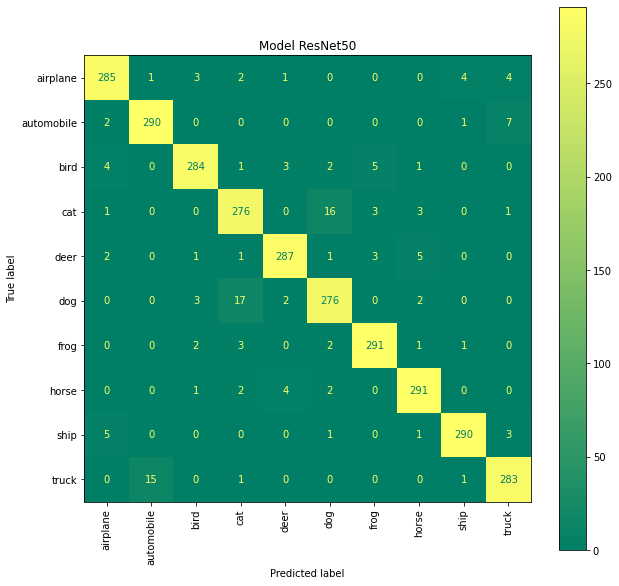

In [31]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.title('Model ResNet50')
plt.show()

# PCA

In [ ]:
# Range of the pixels' values
np.min(x_train),np.max(x_train)

(0, 255)

In [ ]:
# After normalization
np.min(x_train),np.max(x_train)

(0.0, 1.0)

In [ ]:
x_train.shape

(50000, 32, 32, 3)

In [ ]:
# Flat of the images
x_train_flat = x_train.reshape(-1,3072)

In [ ]:
feat_cols = ['pixel'+str(i) for i in range(x_train_flat.shape[1])]

In [ ]:
# Creation of a DataFrame, each row represents an image with its pixels and label 
df_cifar = pd.DataFrame(x_train_flat,columns=feat_cols)

In [ ]:
df_cifar['label'] = y_train
print('Size of the dataframe: {}'.format(df_cifar.shape))

Size of the dataframe: (50000, 3073)


In [ ]:
df_cifar.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel3063,pixel3064,pixel3065,pixel3066,pixel3067,pixel3068,pixel3069,pixel3070,pixel3071,label
0,0.231373,0.243137,0.247059,0.168627,0.180392,0.176471,0.196078,0.188235,0.168627,0.266667,...,0.847059,0.721569,0.549020,0.592157,0.462745,0.329412,0.482353,0.360784,0.282353,6
1,0.603922,0.694118,0.733333,0.494118,0.537255,0.533333,0.411765,0.407843,0.372549,0.400000,...,0.560784,0.521569,0.545098,0.560784,0.525490,0.556863,0.560784,0.521569,0.564706,9
2,1.000000,1.000000,1.000000,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,...,0.305882,0.333333,0.325490,0.309804,0.333333,0.325490,0.313726,0.337255,0.329412,9
3,0.109804,0.098039,0.039216,0.145098,0.133333,0.074510,0.149020,0.137255,0.078431,0.164706,...,0.211765,0.184314,0.109804,0.247059,0.219608,0.145098,0.282353,0.254902,0.180392,4
4,0.666667,0.705882,0.776471,0.658824,0.698039,0.768627,0.694118,0.725490,0.796078,0.717647,...,0.294118,0.309804,0.321569,0.278431,0.294118,0.305882,0.286275,0.301961,0.313726,1


In [ ]:
# PCA is applied on all the columns except the last one
pca_cifar = PCA(n_components=2)
principalComponents_cifar = pca_cifar.fit_transform(df_cifar.iloc[:,:-1])

In [ ]:
principal_cifar_Df = pd.DataFrame(data = principalComponents_cifar
             , columns = ['principal component 1', 'principal component 2'])
principal_cifar_Df['y'] = y_train

In [ ]:
principal_cifar_Df.head()

,principal component 1,principal component 2,y
0,-6.401115,2.729430,6
1,0.829712,-0.949850,9
2,7.730128,-11.521974,9
3,-10.347889,0.010870,4
4,-2.625723,-4.969110,1


In [ ]:
print('Explained variation per principal component: {}'.format(pca_cifar.explained_variance_ratio_))

Explained variation per principal component: [0.29076764 0.11253193]


It appears that a fair amount of information was retained from the first and second principal components, as the data was projected from 3072 dimensions to just two principal components.

It's time to visualize CIFAR-10 data in a two-dimensional space. Remember that there is some overlap of semantic classes in this dataset, meaning that a frog can be shaped slightly like a cat or a deer with a dog; especially when projected into a two-dimensional space. The differences between them may not be captured so well.

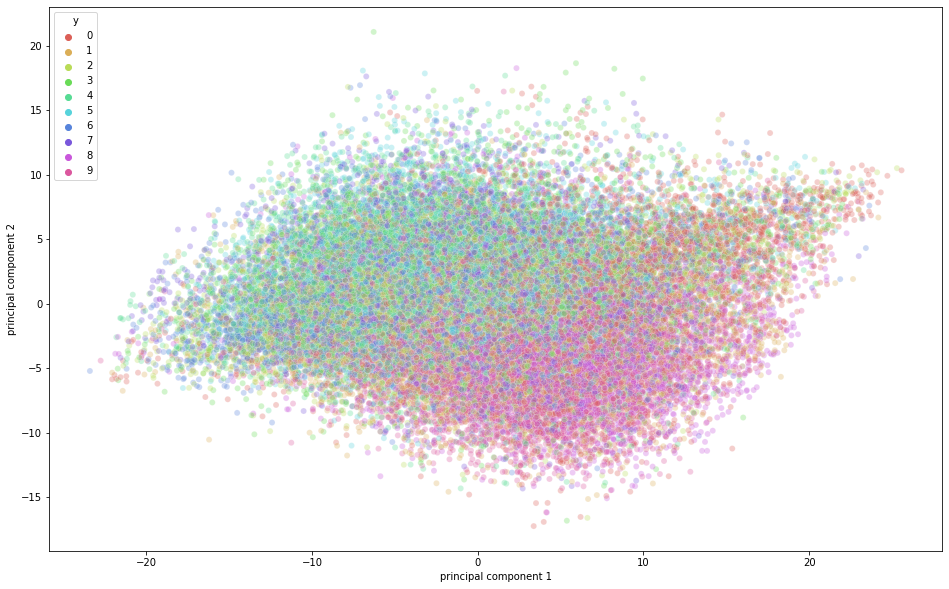

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=principal_cifar_Df,
    legend="full",
    alpha=0.3
)

#plt.savefig('PCA.png', dpi=300, facecolor='w', bbox_inches='tight', pad_inches=0)

From the figure above, you can see that some variation has been captured by the principal components as there is some structure to the points when projected along the axis of the two principal components. Points belonging to the same class are close to each other and points or images that are very different semantically are farther from each other.